# Week 4 - Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, using a function from a couple weeks ago `loadTextDirectory`:

In [2]:
kennedyDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases/Kennedy/')
kennedyDF[:5]

,text
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...


In [6]:
kennedyDF['text'].loc['01Apr2005Kennedy14.txt']

'         FOR IMMEDIATE RELEASE   FOR IMMEDIATE RELEASE                      CONTACT  Melissa Wagoner   Brent Carney                         202  224 2633                             Boston  MA   Senator Edward M  Kennedy announced today that Worcester Polytechnic Institute will receive a  197 000 grant under the Business and International Education program of the U S  Department of Education     WPI will use the funds for a three part project on South Africa to improve understanding of South Africa and its economy  to enable WPI students to study in South Africa  and to strengthen New England companies  involvement in South Africa  WPI has received federal funds for the past three years under the Business and International Education program for a project focusing on Namibia    Senator Kennedy said  One of the principle challenges facing our country and our economy today is globalization  This grant will enable WPI to work with the South African business community and the Corporate Cou

This gets us one Senator's data, but with no metadata, we can add a category column with a simple command:

In [24]:
kennedyDF['category'] = 'Kennedy'
kennedyDF[:5]
print(kennedyDF.shape)

(1695, 2)


We also will be wanting to load all the senators so we will need to loop over all the directories

In [23]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorDir in (file for file in os.scandir(dataDir) if not file.name.startswith('.') and file.is_dir()):
    senDF = lucem_illud.loadTextDirectory(senatorDir.path)
    senDF['category'] = senatorDir.name
    senReleasesDF = senReleasesDF.append(senDF, ignore_index = False)

senReleasesDF[:5]
print(senReleasesDF.shape)

(3904, 2)


We also want to remove stop words and stem. Tokenizing requires two steps. Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone. As such, tokenizing is slightly more involved, but we can still use `lucem_illud`.

In [25]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

senReleasesDF[:5]

,text,category,tokenized_sents,normalized_sents
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, wash..."
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, wash..."
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."


In [66]:
len(senReleasesDF['normalized_sents'].sum())

12189

In [72]:
len(senReleasesDF['normalized_sents'].iloc[0])

1

In [73]:
senReleasesDF['normalized_sents'].shape

(3904,)

# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data, we give all the sentences to the trainer. We just need to add the words as a list of sentences:

In [26]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object, the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [27]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president']

A 100 dimesional vector:


array([-1.433569  , -0.7826857 ,  2.8811958 ,  1.8447134 ,  0.14551347,
        0.8390942 , -0.2960424 , -1.8985376 , -0.59322137, -0.5051169 ,
       -0.8729193 , -0.21301606, -0.43774554,  2.2468715 ,  1.8341194 ,
        0.89525926,  0.268831  , -1.8826382 ,  2.6989112 ,  1.6272871 ,
       -1.7134049 , -1.4926276 , -2.006895  ,  0.12137962,  1.4714507 ,
       -0.01153368,  0.7970137 ,  0.4610031 ,  2.3048482 , -0.6862379 ,
        0.05303238,  1.5823098 ,  1.9117137 ,  1.0985184 ,  3.215736  ,
       -0.24820112, -0.28023827, -0.49140403,  1.4972844 , -1.2271765 ,
        2.6486542 ,  2.4718997 ,  2.400561  ,  0.4229103 , -1.7894607 ,
       -0.47700527, -1.3740549 , -2.4842637 , -1.340583  ,  0.36671394,
        0.9838331 ,  2.5948434 , -1.0595235 ,  0.9739978 ,  0.8871764 ,
       -0.75040054,  1.3011566 , -0.38830245,  1.8545597 ,  1.7171478 ,
       -0.23608907,  1.6052977 ,  1.0314302 ,  0.4111951 , -1.2249784 ,
       -1.6424099 ,  0.7866443 ,  1.1891826 , -1.2586123 ,  0.38

If you want the full matrix, `syn0` stores all the vectors:

In [28]:
senReleasesW2V.wv.syn0

array([[-1.3895957 ,  1.5683088 ,  1.3861742 , ..., -1.5022072 ,
         1.1521007 , -0.20200336],
       [-0.5575102 ,  2.0421858 ,  1.5272644 , ...,  2.7451205 ,
        -1.2460841 , -1.6573452 ],
       [ 1.2152147 ,  1.9893101 ,  0.54608136, ..., -0.2347849 ,
         2.0916677 ,  0.8018893 ],
       ...,
       [-0.07900767,  0.1591431 ,  0.01375983, ...,  0.02328289,
         0.05777476, -0.03255299],
       [-0.06109281,  0.17111456,  0.00748353, ...,  0.00738642,
         0.02123504,  0.00462922],
       [-0.02673694,  0.02006331, -0.02365317, ...,  0.01822415,
        -0.01389961, -0.03909329]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words

In [62]:
senReleasesW2V.wv.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [30]:
senReleasesW2V.most_similar('president')

[('presidents', 0.7687966823577881),
 ('administration', 0.7623358964920044),
 ('administrations', 0.6524640321731567),
 ('george', 0.6003487706184387),
 ('cheney', 0.5963759422302246),
 ('ronald', 0.5331791639328003),
 ('presidential', 0.528479814529419),
 ('quoting', 0.52727872133255),
 ('sticklers', 0.5190844535827637),
 ('responds', 0.5157431960105896)]

In [31]:
senReleasesW2V.most_similar('war')

[('disobedience', 0.6863107681274414),
 ('wars', 0.6639441251754761),
 ('unresisted', 0.642397403717041),
 ('descending', 0.6172688603401184),
 ('quagmire', 0.6119911670684814),
 ('battle', 0.6018742918968201),
 ('chaos', 0.5999463200569153),
 ('afghanistan', 0.5978233218193054),
 ('militarily', 0.5929114818572998),
 ('eviction', 0.5846428871154785)]

Or we can get this directly (calculated slightly differently):

In [32]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [33]:
cos_difference(senReleasesW2V, 'war', 'unwinnable')

array([[0.5519813]], dtype=float32)

We can also find which word least matches the others within a word set (cosine similarity):

In [34]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [35]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('bush', 0.6853550672531128),
 ('veto', 0.6773339509963989),
 ('vetoed', 0.6758346557617188),
 ('signed', 0.6624413132667542),
 ('blocked', 0.6398318409919739),
 ('bushs', 0.6356370449066162),
 ('signature', 0.6185865998268127),
 ('vetoes', 0.6078758239746094),
 ('proposing', 0.5894321799278259),
 ('sign', 0.5812283754348755)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset and period, **Clinton** was to **Democrat** as **Bush** was to **Republican**. Whoah!

 But how do we argue that these are stable distances or associations?

## Establishing Credible or Confidence Intervals

### Boostrapping approach

We propose well-established bootstrapping and subsampling methods to nonparametrically demonstrate the stability and significance of word associations within our embedding model. These allow us to establish conservative confidence intervals to both (a) distances between words in a model and (b) projections of words onto an induced dimension (e.g., man-woman). If we assume that the texts (e.g., newspapers, books) underlying our word embedding model are observations drawn from an independent and identically distributed (i.i.d.) population of cultural observations, then bootstrapping allows us to estimate the variance of word distances and projections by measuring those properties through sampling the empirical distribution of texts with replacement (Efron and Tibshirani 1994; Efron 2003). Operationally, if we wanted to bootstrap a 90% confidence interval of a word-word distance or word-dimension projection, we would sample a corpus the same size as the original corpus, but with replacement, 20 times, estimate word embedding models on each sample. Then we take the 2nd order (2nd smallest) statistic $s_{(2)}$--either distance or projection--as our confidence interval’s lower bound, and 19th order statistic $s_{(19)}$ as its upper bound. The distance between $s_{(2)}$ and $s_{(19)}$ across 20 bootstrap samples span the 5th to the 95th percentiles of the statistic’s variance, bounding the 90th confidence interval. A 95% confidence interval would span $s_{(2)}$ and $s_{(39)}$ in word embedding distances or projections estimated on 40 bootstrap samples of a corpus, tracing the 2.5th to 97.5th percentiles. 

In [36]:
estimatesB=[]
for x in range(20):
    senReleasesW2VB = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB.append(cos_difference(senReleasesW2VB, 'war', 'unwinnable')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
                                                      
estimatesB.sort()         
estimatesB

[0.20787026,
 0.2649511,
 0.2809067,
 0.38607526,
 0.4141336,
 0.4145932,
 0.41846305,
 0.43737254,
 0.43892083,
 0.44056407,
 0.4419832,
 0.4430184,
 0.44477922,
 0.44498932,
 0.4774122,
 0.48836705,
 0.51063836,
 0.5531659]

In [37]:
print("The 90% confidence interval for the cosine distance between war and unwinnable is:\n",estimatesB[1], estimatesB[-2])

The 90% confidence interval for the cosine distance between war and unwinnable is:
 0.2649511 0.51063836


### Subsampling approach

If the corpus is large, then we may take a subsampling approach, which randomly partitions the corpus into non-overlapping samples, then estimates the word-embedding models on these subsets and calculates confidence intervals as a function of the empirical distribution of distance or projection statistics and number of texts in the subsample (Politis and Romano 1997). Subsampling requires the same i.i.d. assumption as the bootrap (Politis and Romano 1992; Politis and Romano 1994). For 90% confidence intervals, we randomly partition the corpus into 20 subcorpora, then calculate $B^k=\sqrt{\tau_k}\left(s^k-\bar{s}\right)$ for each $k$th sample, where $k$ is the number of texts and $s^k$ is the embedding distance or projection for the $k$th sample, and $\bar{s}$ is the average statistic for all samples. The 90% confidence interval spans the 5th to 95th percentile variances, inscribed by $\bar{s}-\frac{B_{(19)}^k}{\sqrt{\tau}}$ and $\bar{s}-\frac{B_{(2)}^k}{\sqrt{\tau}}$, where $\tau$ the number of texts in the total corpus and $s$ is the average statistic across all subsamples. As with bootrapping, a 95% confidence interval would require 40 subsamples; a 99% confidence would require 200 (.5th to 99.5th percentiles).

In [100]:
n_samples = 10
sample_indices = np.random.randint(0,n_samples,(len(senReleasesDF),))

s_k =np.array([])
tau_k=np.array([])

for i in range(n_samples):
    sample_w2v = gensim.models.word2vec.Word2Vec(senReleasesDF[sample_indices == i]['normalized_sents'].sum())
    try:
        #Need to use words present in most samples
        s_k = np.append(s_k, cos_difference(sample_w2v, 'war', 'responsibility')[0,0])
    except KeyError:
        pass
    else:
        tau_k = np.append(tau_k, len(senReleasesDF[sample_indices == i]))

print(s_k)
print(tau_k)

tau = tau_k.sum()
s = s_k.mean()
B_k = np.sqrt(tau_k) * s_k-s_k.mean()

[0.99679786 0.99413508 0.99276519 0.9954747  0.98444116 0.95395982
 0.99707359 0.91972029 0.87387425 0.88883048]
[378. 416. 368. 364. 372. 377. 382. 423. 397. 427.]


In [101]:
print("The 90% confidence interval for the cosine distance between war and responsibility is:\n",s-B_k[-2]/np.sqrt(tau), s-B_k[1]/np.sqrt(tau))

The 90% confidence interval for the cosine distance between war and responsibility is:
 0.6963975776778111 0.6505502004840942


We can also save the vectors for later use:

In [41]:
senReleasesW2V.save("senpressreleasesWORD2Vec.mm")
#Load with senReleasesW2V = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

## Visualize

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [42]:
numWords = 150
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [43]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-1.3895957 ,  1.5683088 ,  1.3861742 , ..., -1.5022072 ,
         1.1521007 , -0.20200336],
       [-0.5575102 ,  2.0421858 ,  1.5272644 , ...,  2.7451205 ,
        -1.2460841 , -1.6573452 ],
       [ 1.2152147 ,  1.9893101 ,  0.54608136, ..., -0.2347849 ,
         2.0916677 ,  0.8018893 ],
       ...,
       [ 0.55731505,  2.435592  , -0.7070612 , ...,  0.42231756,
        -2.013576  , -0.7716261 ],
       [ 1.418117  ,  0.6429205 ,  0.29532123, ..., -0.51904243,
         0.1719056 , -0.00757684],
       [-1.8690441 ,  0.6859688 , -0.72343355, ...,  0.80372447,
        -0.22456689, -1.3175472 ]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [44]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

We now can plot the points

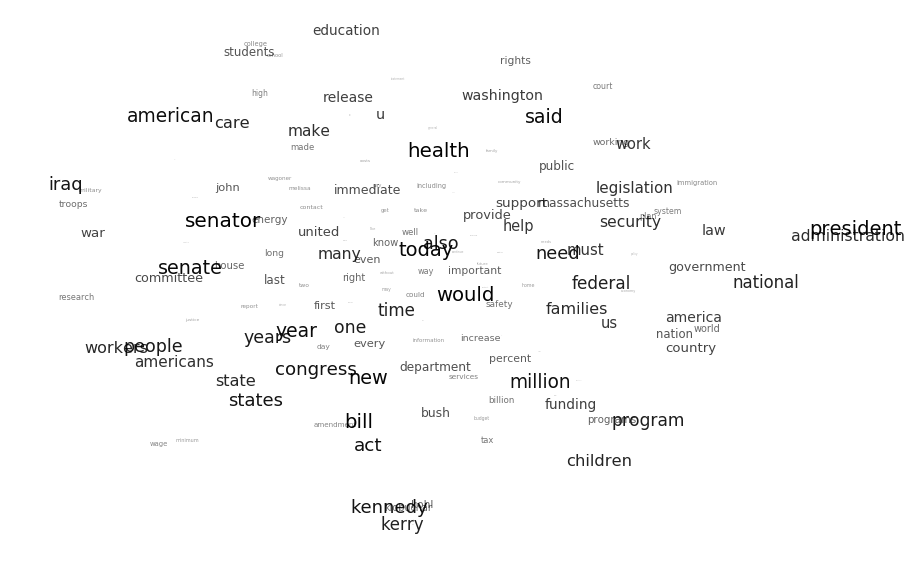

In [45]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``iraq`` next to ``time`` and ``bill`` near ``help``. <img src='../data/examplewordcloud.svg'>

What if a new senator come along with whose names starts with K? Could we analyse their releases too without rerunning the entire embedding? Lets try with Cardin in `../data/grimmerPressReleases_extra/Cardin`. First we need to load and proccess the releases:

In [46]:
cardinDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases_extra/Cardin')
cardinDF['category'] = 'Cardin'

cardinDF['tokenized_sents'] = cardinDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
cardinDF['normalized_sents'] = cardinDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

cardinDF[:10]

,text,category,tokenized_sents,normalized_sents
01Aug2007Cardin156.txt,...,Cardin,"[[CARDIN, MIKULSKI, PRAISES, PASSAGE, OF, STRO...","[[cardin, mikulski, praises, passage, strong, ..."
01Feb2007Cardin297.txt,...,Cardin,"[[CARDIN, VOTES, TO, INCREASE, MINIMUM, WAGE, ...","[[cardin, votes, increase, minimum, wage, pay,..."
01Feb2007Cardin298.txt,...,Cardin,"[[S, 453, SEN, CARDIN, CO, SPONSORS, BILL, TO,...","[[sen, cardin, co, sponsors, bill, protect, vo..."
01Feb2007Cardin299.txt,...,Cardin,"[[S, 450, CARDIN, INTRODUCES, BILL, TO, ELIMIN...","[[cardin, introduces, bill, eliminate, arbitra..."
01Jun2007Cardin199.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 7, 3, MILLION, F...","[[cardin, mikulski, announce, million, hagerst..."
01Jun2007Cardin200.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 4, 6, MILLION, F...","[[cardin, mikulski, announce, million, salisbu..."
01Mar2007Cardin279.txt,...,Cardin,"[[SEN, CARDIN, FIGHTS, TO, IMPROVE, SECURITY, ...","[[sen, cardin, fights, improve, security, amer..."
01Mar2007Cardin280.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 35, 000, FOR, WE...","[[cardin, mikulski, announce, western, marylan..."
01May2007Cardin228.txt,...,Cardin,"[[STATEMENT, BY, U, S, SENATOR, BENJAMIN, L, C...","[[statement, u, senator, benjamin, l, cardin, ..."
01May2007Cardin229.txt,...,Cardin,"[[CARDIN, TELLS, THE, AG, COMMITTEE, THAT, THE...","[[cardin, tells, ag, committee, farm, bill, co..."


We can now merge Cardin's releases with the rest. This can update all the weights in *w2v* model, so be careful.

In [47]:
#This is using a newer API so we have to tell it a little bit more for it to work right
senReleasesW2V.build_vocab(cardinDF['normalized_sents'].sum(), update=True)
senReleasesW2V.train(cardinDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=senReleasesW2V.iter)
senReleasesW2V.save("senpressreleasesWORD2Vec_new.mm")

As the model is updated by this, we need to load our old copy to do a comparison.

In [48]:
senReleasesW2V_old = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

In [49]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president'][:10]

A 100 dimesional vector:


array([-1.4733962 , -0.4203737 ,  3.1177258 ,  2.0535214 , -0.19414824,
        0.52872056, -0.37675014, -1.8170717 , -0.18464066, -0.34665114],
      dtype=float32)

In [50]:
print("A {} dimesional vector:".format(senReleasesW2V_old['president'].shape[0]))
senReleasesW2V_old['president'][:10]

A 100 dimesional vector:


array([-1.433569  , -0.7826857 ,  2.8811958 ,  1.8447134 ,  0.14551347,
        0.8390942 , -0.2960424 , -1.8985376 , -0.59322137, -0.5051169 ],
      dtype=float32)

In [51]:
(senReleasesW2V_old['president'] - senReleasesW2V['president'])[:10]

array([ 0.03982723, -0.362312  , -0.23653007, -0.20880795,  0.33966172,
        0.31037366,  0.08070773, -0.08146596, -0.40858072, -0.15846574],
      dtype=float32)

As you can see the vector for 'president' has changed a little bit and the word cloud should also be a bit different too

In [52]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

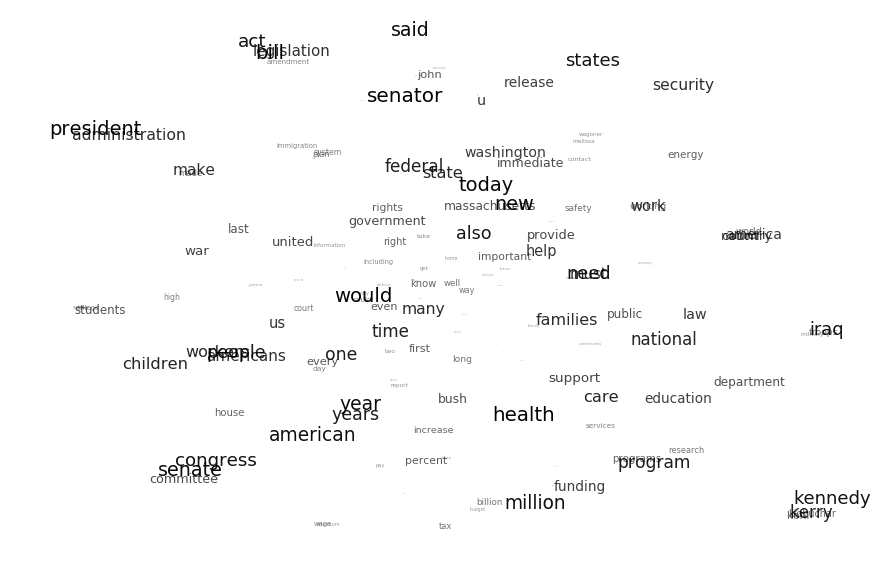

In [53]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

Another thing to consider in training is how we know that our parameters for the model are correct. We can do this by looking at the training loss of the model. Let's tart by training a new model, but this time we will expose most of the options and train it one epoch at a time. Look [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) for more detail: 

In [54]:
senReleasesW2V_loss = gensim.models.word2vec.Word2Vec(size = 100, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
senReleasesW2V_loss.build_vocab(senReleasesDF['normalized_sents'].sum())
senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
#Using a list so we can capture every epoch
losses = [senReleasesW2V_loss.running_training_loss]
losses[0]

1989312.5

Now we have the training loss and can optimize training to minimize it.

In [103]:
for i in range(19):
    senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1,
                             )
    losses.append(senReleasesW2V_loss.running_training_loss)
    print("Done epoch {}".format(i + 2), end = '\r')

Lets plot the loss vs epoch

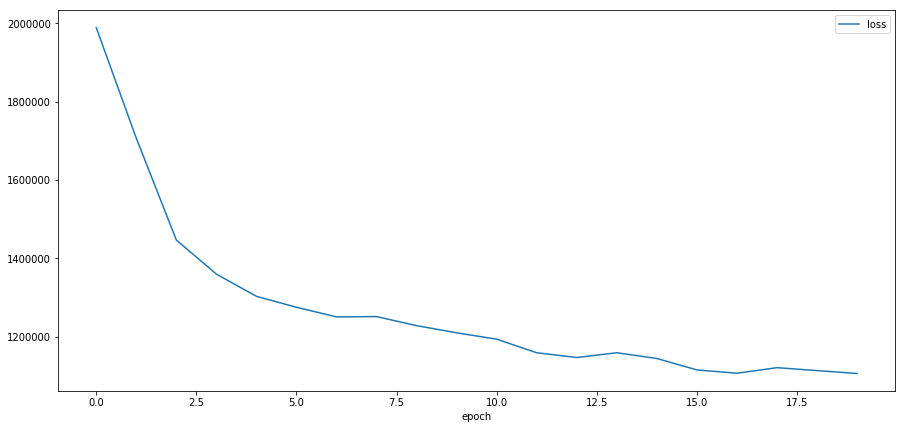

In [56]:
lossesDF = pandas.DataFrame({'loss' : losses, 'epoch' : range(len(losses))})
lossesDF.plot(y = 'loss', x = 'epoch', logy=False, figsize=(15, 7))
plt.show()

You should see that the loss is almost monotonic, but that the rate decreases as epoch increases. Since we are testing on our training data monotonicity is a common result and we must try to avoid over fitting. A simple way to do this is to stop training when there is significant change in the rate of decrease. In this run, that looks to be approximately 8 or 9. If we were to do another analysis, we might use an `iter=9` instead of the default 5.

Even more culturally interesting is how many dimensions are required to achieve an optimal embedding. The use of words in complex ways and contradictory contexts will require more dimensions to represent them with integrity. For example, if one word, $w_a$, is "nearby" $w_b$, but $w_b$ is not near the other words beside $w_a$, then a new dimension will be required for the two words to be uniquely together. 

In [58]:
losses_dims=[]

for d in [50,100,150,200,250,300,350,400,450,500, 550, 600, 650, 700, 750]:
    senReleasesW2V_loss_dims = gensim.models.word2vec.Word2Vec(size = d, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
    senReleasesW2V_loss_dims.build_vocab(senReleasesDF['normalized_sents'].sum())
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=7, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    
    losses_dims.append(senReleasesW2V_loss_dims.running_training_loss/(10+d*10))

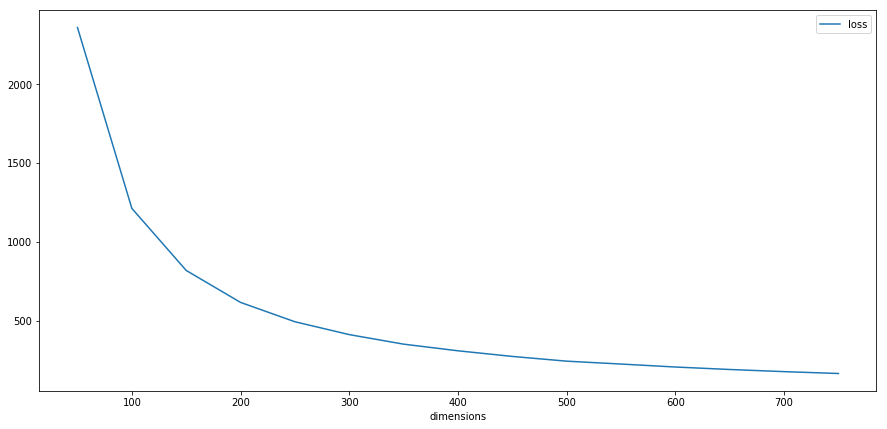

In [102]:
losses_dimsDF = pandas.DataFrame({'loss' : losses_dims, 'dimensions' : [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750]})
losses_dimsDF.plot(y = 'loss', x = 'dimensions', logy=False, figsize=(15, 7))
plt.show()

This is a work in progress for Gensim, but its clear that most of the word distance variation is captured by 300 dimensions.

# Chinese examples

In [80]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [81]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

西安 0.36609965562820435
Xi'an


In [82]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

武汉 0.3677000403404236
Wuhan


Second, location analogy: **country -> capital**

In [83]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

华盛顿 0.508813738822937
(Washington DC)


## similar words

In [84]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 社会主义 is: 
特色
市场经济
理论
建设
改革开放
马克思主义
党
经济体制
基本路线
现代化



In [85]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 玉米 is: 
小麦
水稻
作物
棉花
新品种
杂交
大豆
增产
栽培
农作物



## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that build a word2vec model with your corpus. Interrogate word relationships in the resulting space, including estimating 90% confidence intervals for specific word cosine distances of interest. Plot a subset of your words. What do these word relationships reveal about the *social* and *cultural game* underlying your corpus? What was surprising--what violated your prior understanding of the corpus? What was expected--what confirmed your knowledge about this domain?

## Prepare for data

My corpus contains 54 translated English novels from China, Korea, and U.S. 

- The majority of the translated Chinese novels could be categorized to a genre called eastern fantasy as it involve topics such as Kung Fu, Sage, Chinese   gods, etc.                                                            

- The majority of the translated Korean novels could be only categorized as fantasy. Korean novels is heavily influenced by its western counterparts. They first mimic the western novels, and gradually develope its own characteristics and style.                                        

- The U.S. novels are composed by western online readers, who are inspired by these Chinese and Korean novels and started their own literary attempt

In [468]:
bookDF = pandas.read_csv('bookDF.csv', sep = ';', usecols = list(range(1,5)))
bookDF.loc[1:10]

,author,country,name,text
1,I Am Superfluous,China,Ancient Strengthening Technique,This is a small village surrounded by hills an...
2,Yanbi Xiaosheng,China,Emperor's Domination,“Baa baa… baa baa… baa baa.” A young shepherd’...
3,Warring Blades,China,Imperial God Emperor,The time of 4 years quickly flew by. Ye Qingyu...
4,Ni Cangtian,China,Lord of All Realm,"Black Cloud City. The Nie clan. As night fell,..."
5,Misty Rain of Jiangnan,China,Monarch of Evernight,Although it had been twelve hundred years sinc...
6,Er Geng,China,Renegade Immortal,Tie Zhu was sitting on the side of a little ro...
7,Against the Heavens,China,Spirit Realm,Ling Town. Early morning. Young Qin Lie blankl...
8,Xiao Jingyu,China,Talisman Emperor,Chen Xi Dusk fell upon Pine Mist City in the...
9,Sui Bo Zhu Liu,China,The Grandmaster Strategist,"In the sixteenth year of Xiande, Suiyun left J..."
10,Er Geng,China,A Will Eternal,"Mount Hood lay in the Eastwood Mountain Range,..."


To remove stop words and stem my corpus
- first tokenize sentences to capture a "continuous bag of words (CBOW)"
- next normalize sentences

In [469]:
bookDF['tokenized_sents'] = bookDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
bookDF['normalized_sents'] = bookDF['tokenized_sents'].apply(lambda x:          
             [lucem_illud.normalizeTokens(s,                                    
                                          stopwordLst = lucem_illud.stop_words_basic, 
                                          stemmer = None) for s in x])

Use the processed corpus (sentences) to build a word2vec model 

In [106]:
bookW2V = gensim.models.word2vec.Word2Vec(bookDF['normalized_sents'].sum())  

## Exploratory Text Analysis

Since the majority of these novels are eastern fantasies involving many fighting and action scenes. I am interested to check vector associated to 'punch'.

In [107]:
print("A {} dimesional vector:".format(bookW2V['punch'].shape[0]))              
bookW2V['punch']

A 100 dimesional vector:


array([ 0.21545482, -0.13353255,  0.42069307,  1.4800746 , -0.50597054,
        0.5330378 , -0.78050107,  0.312119  ,  0.585732  , -0.08045596,
       -0.6202208 ,  0.07890268, -0.11236972,  0.86628443, -0.46156213,
        0.32589805,  0.10549331, -1.1757619 , -0.308077  , -0.4450815 ,
        0.5076246 , -0.12888634,  1.586465  ,  0.0891854 , -0.83097494,
        0.04939921, -0.18987961, -0.5949004 ,  0.24094677, -0.19385558,
       -0.3246298 , -0.7033898 , -0.05172908,  0.61108375, -0.2662229 ,
       -0.4354698 , -0.3548668 , -0.05639441, -0.39131758,  0.30978283,
       -0.6598213 ,  0.03654239, -0.04822986,  0.86965984, -1.3456192 ,
        1.1139328 ,  0.72040707, -0.716875  , -0.59088475,  0.48109168,
        0.22588795, -0.14926668,  0.5108179 , -0.04480186,  0.04052359,
       -0.34623384,  1.3216875 , -0.58703005, -0.5175313 ,  0.68893224,
       -0.13110648, -0.4402295 ,  0.24136259, -0.4058094 , -0.66106474,
        0.74632925,  0.27515215, -0.00585751, -0.31053382,  0.23

Find similar vectors by cosine similarity                                 
- Because many scenes in these novels involves fighting so I tried some words and to assess their most similiar counterparts using cosine similarity.
    + As expected, looking at similar words of "kick", it would return "knee" (used to kick), "aiming" (aim where to kick), "dodge" (avoid being kicked), etc.
    + Similarily, "punch" works the same way: "strike" (make a punch), "elbow" (used to punch). Also, interestingly, it is related to "kick"! Which proves the amount of fighting in these. novels.
    + Similar words related to "strong" is also interesting to analyze. Notably, "tyrannical", "fearsome", and "stronger". It is interesting how sroing could be associated with "tyrannical" and I would suspect it has certain Chinese aspect in it. What is even more interesting is strong strongly related to "stronger". It implies in these novels, leading characters usually always in the journey of being "strong" and "powerful". They tend to become "stronger".
    + It is very interesting to see similar words related to "fight" are almost a set of positive words: "win", "capture", "eliminate", "survive", etc. It implies in these books, whenever there is fight, the author would always make some paragraphs describing the outcome of the fight. Very likely, the leading character always wins.

In [110]:
wordTestLst = ['kick', 'punch', 'strong', 'fight']
[ [[bookW2V.most_similar(word)] for word in wordTestLst] ]

[[[[('rotwolf', 0.8471933007240295),
    ('knee', 0.8326289653778076),
    ('punch', 0.8158336281776428),
    ('dodged', 0.8152846097946167),
    ('alpha', 0.8014132976531982),
    ('elbow', 0.7945905327796936),
    ('machete', 0.7809563875198364),
    ('leg', 0.7687615156173706),
    ('aiming', 0.763865053653717),
    ('avoiding', 0.7601113319396973)]],
  [[('strike', 0.8438123464584351),
    ('blow', 0.8202847242355347),
    ('kick', 0.8158336281776428),
    ('knee', 0.7970518469810486),
    ('rotwolf', 0.7961857318878174),
    ('elbow', 0.7722077369689941),
    ('arrow', 0.7607300281524658),
    ('bullet', 0.7595688700675964),
    ('leg', 0.7589878439903259),
    ('hit', 0.7432653903961182)]],
  [[('powerful', 0.7774147987365723),
    ('weak', 0.7735790014266968),
    ('tough', 0.6879231333732605),
    ('tyrannical', 0.6810244917869568),
    ('fearsome', 0.6808481216430664),
    ('formidable', 0.6638286113739014),
    ('frightening', 0.6483249664306641),
    ('astonishing', 0.638452

Interestingly, when I tried to assess some emotional and colloquial words such as "damn", it would return a list of derogratory words and vulgarity. I think this is more of a cultural factor playing in it.

In [111]:
bookW2V.most_similar('damn')                                                    

[('shit', 0.8251016736030579),
 ('stupid', 0.8223826289176941),
 ('fuck', 0.8107476234436035),
 ('fucking', 0.7954457402229309),
 ('idiot', 0.7886371612548828),
 ('pretending', 0.7773348093032837),
 ('pretend', 0.7697337865829468),
 ('yeah', 0.7607200741767883),
 ('wow', 0.7567509412765503),
 ('tsk', 0.7500290870666504)]

## Try directly compare two words by their cosine similarity 

Composed a function that would help the process:

In [113]:
def cos_difference(embedding,word1,word2):                                      
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [130]:
cos_difference(bookW2V, 'girl', 'cute') 

array([[0.61651385]], dtype=float32)

In [131]:
cos_difference(bookW2V, 'boy', 'cute') 

array([[0.5245715]], dtype=float32)

Try to find words that least matches the others within a word set through cosine similarity.
- It turns out "blood" is not similiar with the rest, which sort of makes senbse. It is the only noun from the rest of the verbs and the other words are happened during the fight and involves movement, but "blood" is more like of a consequence. 


In [132]:
bookW2V.doesnt_match(['kick', 'punch', 'fight', 'blood', 'dodge'])  

'blood'

## Find which word best matches the result of a semantic equation

I think this particular equation gives most interesting results: love + women - beautiful = ?
It is very interesting to see the results that love + women - beautiful = friends for example

In [176]:
bookW2V.most_similar(positive=['love', 'women'], negative = ['beautiful'])        

[('conflict', 0.6620154976844788),
 ('criminal', 0.660298228263855),
 ('debt', 0.6558755040168762),
 ('matters', 0.6498241424560547),
 ('circumstances', 0.6422643661499023),
 ('friends', 0.6421874761581421),
 ('bastards', 0.6400501728057861),
 ('lives', 0.6377488374710083),
 ('lovesickness', 0.6334631443023682),
 ('parents', 0.6326922178268433)]

This equation strong + men - handsome = warriors etc also makes sense.

In [169]:
bookW2V.most_similar(positive=['strong', 'men'], negative = ['handsome'])         

[('warriors', 0.5977815389633179),
 ('soldiers', 0.5600197315216064),
 ('enemies', 0.5561221837997437),
 ('goblins', 0.5386484861373901),
 ('experts', 0.5339372158050537),
 ('orcs', 0.5268385410308838),
 ('sweepers', 0.5206327438354492),
 ('mercenaries', 0.5128014087677002),
 ('powerful', 0.5079419612884521),
 ('scavengers', 0.5075714588165283)]

The following two equations are particularly interesting. Women without good becomes men and men without good becomes an orcs. This is halirious and we could see the effect of gender in these easter fantasies: women typically would be thought as better than men!

In [183]:
print('women - good = ?')
bookW2V.most_similar(positive=['women'], negative = ['good'])               

women - good = ?


[('men', 0.5543276071548462),
 ('humans', 0.5425444841384888),
 ('beings', 0.5378450751304626),
 ('creatures', 0.5309407114982605),
 ('children', 0.525757372379303),
 ('boys', 0.5105055570602417),
 ('bandits', 0.5044141411781311),
 ('girls', 0.4880167245864868),
 ('figures', 0.4789034128189087),
 ('animals', 0.46356889605522156)]

In [181]:
print('men - good = ?')
bookW2V.most_similar(positive=['men'], negative = ['good'])  

men - good = ?


[('figures', 0.6007112860679626),
 ('orcs', 0.5677449703216553),
 ('soldiers', 0.5576567053794861),
 ('rotwolves', 0.5450668334960938),
 ('jamming', 0.5197687745094299),
 ('wolves', 0.5142285823822021),
 ('bandits', 0.513744056224823),
 ('corpses', 0.5125969052314758),
 ('statues', 0.5051430463790894),
 ('directions', 0.504734992980957)]

## Establishing Credible or Confidence Intervals

Because my corpus is large, a subsampling approach would be used. To easily implement this repeititive process, a function would be constructed to simplify the process. This function will randomly partitions the corpus into non-overlapping samples, then estimates the word-embedding models on these subsets and calculates confidence intervals as a function of the empirical distribution of distance or projection statistics and number of texts in the subsample.

In [263]:
def subsamplingCI(bookDF, n_samples, word1, word2):                             
    sample_indices = np.random.randint(0,n_samples,(len(bookDF),))              
    while len(np.unique(sample_indices)) != n_samples:                          
        sample_indices = np.random.randint(0,n_samples,(len(bookDF),))          
                                                                                
    s_k =np.array([])                                                           
    tau_k=np.array([])                                                          
                                                                                
    for i in range(n_samples):                                                  
        sample_w2v = gensim.models.word2vec.Word2Vec(bookDF[sample_indices == i]['normalized_sents'].sum())
        try:                                                                    
            #Need to use words present in most samples                          
            s_k = np.append(s_k, cos_difference(sample_w2v, word1, word2)[0,0]) 
        except KeyError:                                                        
            pass                                                                
        else:                                                                   
            tau_k = np.append(tau_k, len(bookDF[sample_indices == i]))          
                                                                                
    print("Averaged Cosine Difference in each subcorpora")                      
    print(s_k)                                                                  
    print("Number of obs assigned to each subcorpora")                          
    print(tau_k)                                                                
                                                                                
    tau = tau_k.sum()                                                           
    s = s_k.mean()                                                              
    B_k = np.sqrt(tau_k) * s_k-s_k.mean()
    print("The 90% confidence interval for the cosine distance between {} and {} is:\n".format(word1, word2),
          s-B_k[-2]/np.sqrt(tau), s-B_k[1]/np.sqrt(tau))                        
    return s-B_k[-2]/np.sqrt(tau), s-B_k[1]/np.sqrt(tau)

### Estimating 90% confidence intervals for specific word cosine distances of interest.

Here are the two sets of comparisons I find to be very interesting. When we think about gender bias, we would typically associate gender stereotypes. For example, we would typically assume females to be good-looking and always get complimented on their appearances, while males usually are more associated to high status and great physical strength. However, from using subsampling method to study on gender related words by using cosine differences, I discovered there could be another whole new dimension, which is age. 

It is very intuitive that we typically describe and associate good-looking males to be "handsome" and good-looking "females" to be beautiful. Similarly, we would describe boys as "cute" or girls as "lovely". These four adjectives are simple and I would suspect they would be four most frequently used words to describe appearances of males and females of different age. 

Looking at the confidence intervals below, woman has a narrower and higher confidence interval comparing with man. It means indeed that from those 54 Chinese, Korean, and U.S. novels, we would expect to see woman to be associated with beautiful more often than seeing man to be associated with handsome.  

However, boys and girls are completely different and this trend is reversed. In young ages, boys would be associated with "cute" way more often than girls to be associated to "lovely". Because cute could also be used to describe girls, so I assessed the cosine difference between "girl" and "cute" as well. The result, surprisingly, to be consistent. 

This is a very interesting and suripsing find to gender theory. I think age is a nove dimension when we study gender bias or stereotypes, as proved in this simply analysis. 

In [258]:
subsamplingCI(bookDF, 20, 'man', 'handsome')

Averaged Cosine Difference in each subcorpora
[0.99937135 0.97508657 0.97867537 0.60708016 0.99594986 0.90585107
 0.74900019 0.99808371 0.99723804 0.88905579 0.99943864 0.99538207
 0.97950363 0.99968362]
Number of obs assigned to each subcorpora
[3. 4. 3. 6. 3. 4. 5. 3. 3. 3. 2. 2. 3. 1.]
The 90% confidence interval for the cosine distance between man and handsome is:
 0.8197840501426283 0.7819761531244428


(0.8197840501426283, 0.7819761531244428)

In [200]:
subsamplingCI(bookDF, 20, 'boy', 'cute')

Averaged Cosine Difference in each subcorpora
[0.99544257 0.98136979 0.96589577 0.98546147 0.99356043 0.99772322
 0.97721732 0.98692006 0.99360722 0.99389499 0.99780232 0.93902719]
Number of obs assigned to each subcorpora
[3. 4. 4. 3. 5. 3. 6. 5. 3. 4. 1. 3.]
The 90% confidence interval for the cosine distance between boy and cute is:
 0.9819117773255002 0.83644201051714


(0.9819117773255002, 0.83644201051714)

In [196]:
subsamplingCI(bookDF, 20, 'woman', 'beautiful')

Averaged Cosine Difference in each subcorpora
[0.96440309 0.98797435 0.99978948 0.97903895 0.99972713 0.99966335
 0.99849039 0.95949364 0.99975789 0.9986977  0.99274302 0.9997915
 0.99540174 0.92323935 0.99962842 0.99965215 0.99976122 0.99976516
 0.99924254]
Number of obs assigned to each subcorpora
[3. 4. 1. 7. 2. 1. 1. 5. 1. 2. 4. 4. 4. 4. 3. 3. 2. 1. 1.]
The 90% confidence interval for the cosine distance between woman and beautiful is:
 0.9878362253409423 0.8537471046388105


(0.9878362253409423, 0.8537471046388105)

In [201]:
subsamplingCI(bookDF, 20, 'girl', 'lovely')

Averaged Cosine Difference in each subcorpora
[0.99513668 0.99799353 0.9912473  0.95020354 0.97124022 0.93687516
 0.98652858]
Number of obs assigned to each subcorpora
[3. 3. 3. 6. 5. 3. 3.]
The 90% confidence interval for the cosine distance between girl and lovely is:
 0.8486945041295548 0.8279336280395576


(0.8486945041295548, 0.8279336280395576)

In [202]:
subsamplingCI(bookDF, 20, 'girl', 'cute')

Averaged Cosine Difference in each subcorpora
[0.97178966 0.99668509 0.94041538 0.9969691  0.98325956 0.99870282
 0.9888345  0.99909335 0.99859661 0.98699373 0.99828261 0.99042755
 0.97912627]
Number of obs assigned to each subcorpora
[4. 4. 4. 3. 3. 2. 3. 3. 2. 2. 3. 3. 6.]
The 90% confidence interval for the cosine distance between girl and cute is:
 0.874432572701962 0.831551774942916


(0.874432572701962, 0.831551774942916)

Extending from previous speculation on the 'age' dimension of gender stereotype, I tested another set of words on "man", "woman", "boy" and "girl". This time my words of choice are "smart",  would related to virtue and capability.



When using the word "smart", it could be seen from 4 cells below that woman are more strongly associated to the word "smart" than man does. However ,this trend is completely reversed: "boy" is more strongly associated with "girl".

In [186]:
subsamplingCI(bookDF, 20, 'man', 'smart')

Averaged Cosine Difference in each subcorpora
[0.96781605 0.99558747 0.95654017 0.46015576 0.9916811  0.50019866
 0.63162768 0.9170813  0.50854427 0.99040502 0.95999551 0.9919529 ]
Number of obs assigned to each subcorpora
[1. 1. 3. 8. 2. 6. 5. 3. 2. 3. 3. 3.]
The 90% confidence interval for the cosine distance between man and smart is:
 0.689796123363882 0.7952855203713316


(0.689796123363882, 0.7952855203713316)

In [188]:
subsamplingCI(bookDF, 20, 'woman', 'smart')

Averaged Cosine Difference in each subcorpora
[0.98114789 0.97310966 0.99377251 0.96952385 0.99698293 0.99513751
 0.99753332 0.99818194 0.99687099 0.97979873 0.91389877 0.99753129]
Number of obs assigned to each subcorpora
[5. 5. 3. 6. 3. 3. 1. 3. 2. 3. 5. 2.]
The 90% confidence interval for the cosine distance between woman and smart is:
 0.8171296240510155 0.7964522820761692


(0.8171296240510155, 0.7964522820761692)

In [190]:
subsamplingCI(bookDF, 20, 'boy', 'smart')

Averaged Cosine Difference in each subcorpora
[0.98344785 0.96354109 0.99652517 0.99464685 0.99685138 0.98401767
 0.98815721 0.96832776 0.99173063 0.99772465 0.99748987 0.99686271
 0.9908911  0.99677289]
Number of obs assigned to each subcorpora
[4. 3. 5. 3. 2. 4. 2. 6. 3. 2. 2. 3. 3. 3.]
The 90% confidence interval for the cosine distance between boy and smart is:
 0.8806654292862397 0.8877271711123397


(0.8806654292862397, 0.8877271711123397)

In [192]:
subsamplingCI(bookDF, 20, 'girl', 'smart')

Averaged Cosine Difference in each subcorpora
[0.99652064 0.99825007 0.99482739 0.95349902 0.88921231 0.9984169
 0.99706751 0.97884345 0.99175847 0.99828511 0.95549303 0.99912602
 0.78611469 0.99813008]
Number of obs assigned to each subcorpora
[1. 3. 5. 4. 4. 2. 3. 1. 2. 2. 5. 2. 6. 1.]
The 90% confidence interval for the cosine distance between girl and smart is:
 0.8170922059914442 0.8477897270754298


(0.8170922059914442, 0.8477897270754298)

Similarly, I also tested four different gender nouns on "ability" and "talent" since both words indicate the potential of success. Notice "ability" is more applied to grown-ups and "talent" is more suitable to teens.

The result below is still very consistent. Woman is more directly related to "ability" than man and "boy" is more directly related to "talent" than girl. It shows that in these novels, culturally speaking, in China and Korea, people would typically think of young boys to have more talents than young girls. However, when they grow up, this trend could be reversed: woman would typically associate with ability a lot stronger than man.

In [233]:
subsamplingCI(bookDF, 20, 'man', 'ability')

Averaged Cosine Difference in each subcorpora
[0.71097827 0.96728551 0.99893421 0.53267616 0.99950659 0.97837514
 0.99864179 0.8940829  0.93937635 0.99753684 0.45900631 0.2735799
 0.99948162 0.99977905 0.09654209 0.99627709 0.99804348]
Number of obs assigned to each subcorpora
[5. 5. 2. 4. 2. 3. 2. 3. 4. 2. 5. 2. 1. 1. 5. 3. 2.]
The 90% confidence interval for the cosine distance between man and ability is:
 0.6864911593477881 0.6252550044205814


(0.6864911593477881, 0.6252550044205814)

In [234]:
subsamplingCI(bookDF, 20, 'woman', 'ability')

Averaged Cosine Difference in each subcorpora
[0.99973559 0.99813443 0.99974328 0.98525834 0.99783981 0.99979132
 0.99895144 0.94548476 0.96964681 0.96492261 0.99865699 0.98623228
 0.99945146 0.94263768 0.87993771 0.37850863 0.99361986 0.99768317]
Number of obs assigned to each subcorpora
[1. 1. 1. 4. 2. 3. 2. 4. 2. 5. 1. 3. 2. 4. 5. 5. 3. 4.]
The 90% confidence interval for the cosine distance between woman and ability is:
 0.8390478436022847 0.9392912724327133


(0.8390478436022847, 0.9392912724327133)

In [232]:
subsamplingCI(bookDF, 20, 'boy', 'talent')

Averaged Cosine Difference in each subcorpora
[0.93883657 0.9991675  0.95457786 0.99685562 0.99952924 0.99942327
 0.96718907 0.88650775 0.98215687 0.99665439 0.99600828 0.80065364
 0.99741381 0.98298669 0.99595523 0.99904269]
Number of obs assigned to each subcorpora
[3. 1. 5. 2. 2. 3. 4. 4. 4. 2. 2. 6. 3. 2. 3. 2.]
The 90% confidence interval for the cosine distance between boy and talent is:
 0.8590845943111577 0.9638559949618567


(0.8590845943111577, 0.9638559949618567)

In [231]:
subsamplingCI(bookDF, 20, 'girl', 'talent')

Averaged Cosine Difference in each subcorpora
[0.99097592 0.99058908 0.99818534 0.9991138  0.97305751 0.99943262
 0.94586533 0.92346281 0.98102009 0.99867415 0.99805379 0.99973392
 0.99895412 0.99277288 0.89226443 0.99956334 0.97950864 0.91750455
 0.95637494 0.99953127]
Number of obs assigned to each subcorpora
[5. 1. 2. 2. 4. 1. 3. 3. 5. 2. 3. 3. 1. 2. 5. 1. 2. 5. 2. 2.]
The 90% confidence interval for the cosine distance between girl and talent is:
 0.9255938622622659 0.9748462061150005


(0.9255938622622659, 0.9748462061150005)

Last but not the least, I tried to relate the simple word "good" with these four gender nouns. The result is also interesting. 

Comparing with man, woman has a relatively wider confidence interval. I interpret woman could be very nice/good or very bad/evil in both ways in these novels. At the same time, this trend also applies to boys and girls. Boys are relatively consistent while girls have a smaller lower bound, which indicates girls could be associated with "bad" more frequently in these novels.

In [213]:
subsamplingCI(bookDF, 20, 'man', 'good')

Averaged Cosine Difference in each subcorpora
[0.99934143 0.99970144 0.65050191 0.99805599 0.99668449 0.81594771
 0.99968368 0.35357368 0.99970168 0.95050311 0.99921709 0.99773026
 0.84722084 0.99424815 0.92360568 0.47812152 0.99985403 0.95618248
 0.9995994  0.99392849]
Number of obs assigned to each subcorpora
[3. 1. 2. 1. 1. 5. 2. 6. 2. 3. 2. 1. 5. 4. 4. 4. 1. 3. 2. 2.]
The 90% confidence interval for the cosine distance between man and good is:
 0.8274545941931177 0.8837854532112298


(0.8274545941931177, 0.8837854532112298)

In [212]:
subsamplingCI(bookDF, 20, 'woman', 'good')

Averaged Cosine Difference in each subcorpora
[0.99898577 0.99895155 0.99398404 0.9998346  0.99938649 0.99972892
 0.99928576 0.99805737 0.99941635 0.97140247 0.96754032 0.99841082
 0.99902636 0.99941975 0.99978822 0.99624091 0.99976313 0.99700612
 0.96870166 0.6913169 ]
Number of obs assigned to each subcorpora
[2. 1. 2. 2. 2. 1. 4. 3. 2. 5. 5. 4. 3. 2. 1. 2. 2. 3. 6. 2.]
The 90% confidence interval for the cosine distance between woman and good is:
 0.7891113151370122 0.976071780581861


(0.7891113151370122, 0.976071780581861)

In [210]:
subsamplingCI(bookDF, 20, 'boy', 'good')

Averaged Cosine Difference in each subcorpora
[0.99844438 0.99948055 0.99058586 0.99969739 0.99815524 0.99967146
 0.68923497 0.99926549 0.99737293 0.99339783 0.99948466 0.98336607
 0.98819697 0.99930358 0.96009284 0.99969882 0.99832201 0.99954069
 0.99503243]
Number of obs assigned to each subcorpora
[3. 2. 4. 3. 2. 2. 4. 2. 4. 3. 3. 4. 4. 1. 5. 2. 2. 2. 1.]
The 90% confidence interval for the cosine distance between boy and good is:
 0.9185504520802431 0.9185621349176711


(0.9185504520802431, 0.9185621349176711)

In [211]:
subsamplingCI(bookDF, 20, 'girl', 'good')

Averaged Cosine Difference in each subcorpora
[0.99797118 0.97483879 0.99290454 0.99958861 0.99964619 0.98844653
 0.96343243 0.71005875 0.99359864 0.99879962 0.99983835 0.94778299
 0.97208315 0.99716377 0.99965078 0.99008554 0.99956316 0.99809384
 0.99939102]
Number of obs assigned to each subcorpora
[2. 4. 3. 1. 2. 5. 3. 2. 3. 2. 1. 4. 3. 3. 3. 5. 3. 2. 2.]
The 90% confidence interval for the cosine distance between girl and good is:
 0.9149162220533148 0.8409942971376556


(0.9149162220533148, 0.8409942971376556)

## Visualization

Create a function so as to facilitate plotting.

In [220]:
def createPlot(w2vObject, numWords, n_components):                                 
    targetWords = w2vObject.wv.index2word[:numWords]                               
    # extract their vectors and create our own smaller matrix that preserved the distances from the original
    wordsSubMatrix = []                                                            
    for word in targetWords:                                                       
        wordsSubMatrix.append(w2vObject[word])                                     
    wordsSubMatrix = np.array(wordsSubMatrix)                                      
    wordsSubMatrix                                                                 
    # use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize.
    pcaWords = sklearn.decomposition.PCA(n_components).fit(wordsSubMatrix)         
    reducedPCA_data = pcaWords.transform(wordsSubMatrix)                           
    #T-SNE is theoretically better, but you should experiment                      
    tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)
    # plot                                                                         
    fig = plt.figure(figsize = (15,10))                                            
    ax = fig.add_subplot(111)                                                      
    ax.set_frame_on(False)                                                         
    plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
    for i, word in enumerate(targetWords):                                         
        ax.annotate(word,                                                          
                    (tsneWords[:, 0][i],tsneWords[:, 1][i]),                       
                    size =  20 * (numWords - i) / numWords,                        
                    alpha = .8 * (numWords - i) / numWords + .2)                   
    plt.xticks(())                                                                 
    plt.yticks(())                                                                 
    plt.show()                                                                     
              

Set the number of PCA to be 50 so as to present top 250 words.

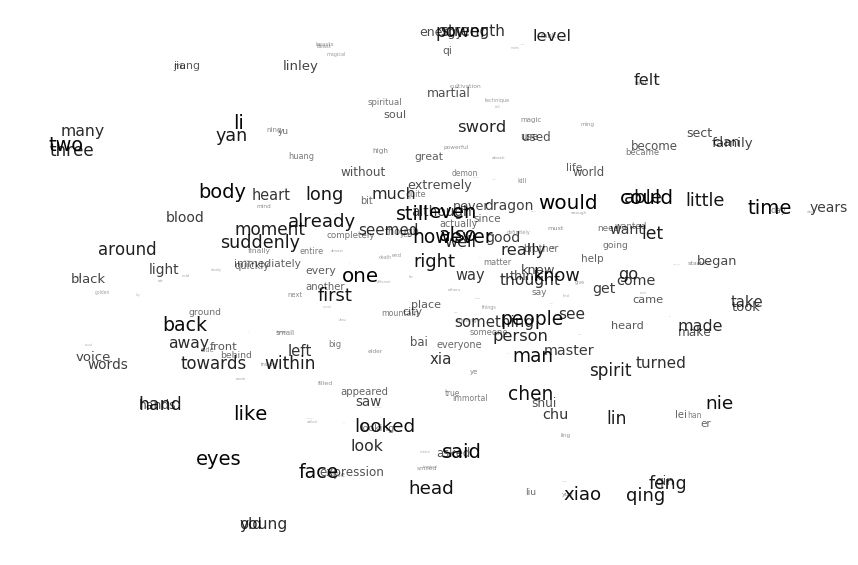

In [238]:
createPlot(bookW2V, 250, 50)

This word cloud is very interesting. First we could see words such as family, sect, and clan on the top right corner of the word cloud. It makes sense becasue it indicates the collectivism of Chinese and Korean culture. Most of the books are about how the protagnist become more and more powerful to protect family, to keep the dignity of their clan, and to revive their sect. 

Another interesting finding would the use of emotional adverbs. I personally have read many of those books in the corpus and I understand one of the writing strategy the authors typically would choose to adapt: to use emotional strong words so as to attract readers following along the book. As expected, in the word cloud, we could see many strong adverbs such as "extremely", "suddenly", "immediately", "completely", and "finally". This is more of the type of writing style Chinese authors widerly use and I do see these writing style being perserved in the English translation.

Set the number of PCA to be 20 so as to present top 250 words.

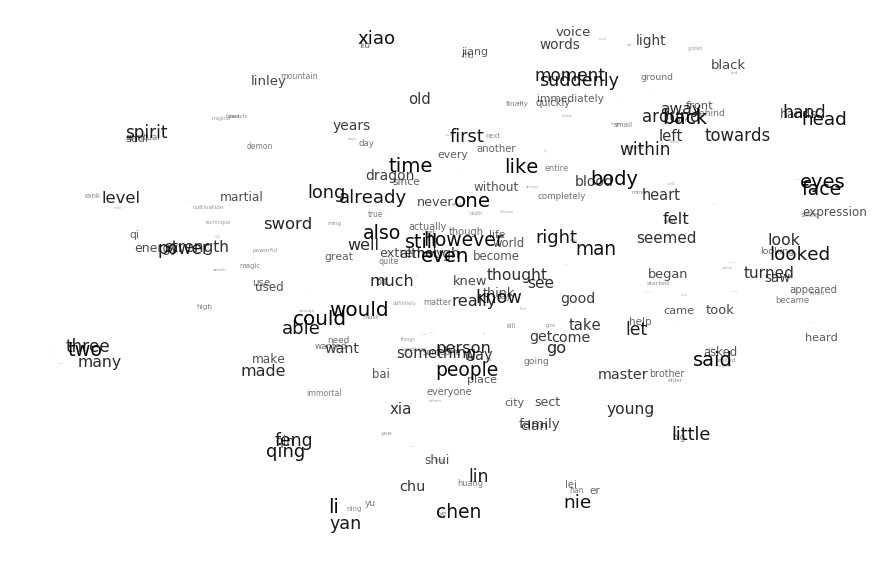

In [239]:
createPlot(bookW2V, 250, 20)

After chanping the number of PCA to be 20, I discovered another interesting cluster in the word cloud. In the left side of the word cloud, we could see words such as "energy", "power", and "strength". In addition, the words surrounding this cluster are "martial", "cultivation", "techniques", "powerful", and "magic". This pattern makes sense to me because in most of novels I chose to be in my corpus, the protagnist would cultivate their techniques so as to become more and more powerful. I think that is why these words would cluster together in the word cloud above. 

In the bottom right of the word cloud above, we could see a cluster of words such as "brother", "master", and "elder". Surrounding that cluster are another clusters such as "help" and "let", showing that elders tend to help those youngs, which matched the Chinese and Korean tradition. 

On the top right corner of the word cloud, we could see many clusters such as "eyes", "expression", and "look", "appeared". I will see it as another writing technique: Chinese and Korean authors tend to vividly describe protagnist's facial expressions in the chapters into as much detail as possible. This technique could typically make the reader to associate more and make the their writing more picturesque. 

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [243]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags

In [276]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [277]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: nltk.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

In [278]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [248]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [249]:
apsD2V.docvecs[1952]

array([ 0.0981588 , -0.54790676, -0.4580304 ,  0.1818154 , -1.1376439 ,
        0.6527656 , -0.46167663, -0.2679592 , -0.63299525,  1.6285836 ,
       -1.4159567 , -1.1176759 , -0.11852523,  1.2034721 , -0.83869725,
       -0.50201833, -0.6028916 , -0.39987916,  0.34700355, -0.9205517 ,
       -0.49028578, -0.55033135, -0.8598551 ,  1.7768866 , -0.03499366,
       -0.3429299 , -0.7191873 , -0.7131913 ,  0.05424064, -0.89979523,
        1.1550665 ,  1.273946  ,  1.2134386 , -1.4757333 ,  1.1288848 ,
       -0.23892874, -0.8107997 ,  1.140118  ,  0.9595265 ,  0.29711014,
       -0.25236672,  0.2581393 ,  1.1083332 , -0.32089105, -0.02960099,
        1.840395  , -0.7204181 ,  0.62927115, -0.81103265,  0.6267605 ,
        0.3693922 , -2.088759  , -0.45402962,  0.44389412, -0.576364  ,
        0.67150307,  1.1893328 ,  0.15286663, -0.7055066 , -0.35844094,
        1.2236892 , -0.35406473,  0.5363644 , -0.63215005,  1.0072366 ,
        0.25977334,  0.9235861 ,  2.1487834 ,  1.2036127 ,  1.33

The words can still be accessed in the same way:

In [250]:
apsD2V['atom']

array([ 0.03264038, -0.19358054, -0.13578685, -0.38644046, -0.48757294,
        0.30862436, -0.7332358 , -0.1250949 , -1.0372841 ,  0.3421092 ,
       -0.7543619 , -0.05055091, -0.3761607 ,  0.75336325, -0.20081116,
        1.0024644 ,  0.01912728, -0.1837386 ,  0.30386734, -1.2352474 ,
        0.6387393 ,  0.38262737, -0.48575062,  0.56385684, -0.62210417,
       -0.55559015, -0.3970032 , -0.1554962 , -0.6340471 , -0.79969037,
        0.3479527 ,  0.4057259 ,  0.9433624 , -0.366585  ,  0.6085977 ,
       -0.25268313, -0.56189734,  0.60368055,  1.0823807 ,  0.5320885 ,
        0.05425638,  0.7977824 ,  0.31523484,  0.56052893, -0.31593496,
        0.72309077, -0.30052087,  0.589235  , -0.48673663,  0.63406044,
       -0.21572858, -0.0204682 ,  0.09489924,  0.02155055, -0.9032428 ,
       -0.2030448 , -0.26689819, -0.36967173, -0.4774204 , -0.47541463,
        1.0390576 ,  0.40316442,  0.3609225 , -0.16317628,  0.555107  ,
        0.3012738 , -0.72947377, -0.0933876 ,  1.0147681 ,  0.31

We can still use the ``most_similar`` command to perform simple semantic equations:

In [251]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.7752963304519653)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [252]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('disordering', 0.9399688243865967)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [264]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.6038162]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [438]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ] )

[('10.1103/PhysRev.100.1646', 0.6798344850540161),
 ('10.1103/PhysRev.112.812', 0.6761063933372498),
 ('10.1103/PhysRev.89.930', 0.6122956871986389),
 ('10.1103/PhysRev.84.457', 0.6099432706832886),
 ('10.1103/PhysRev.110.857', 0.5879626274108887),
 ('10.1103/PhysRev.101.1526', 0.587907612323761),
 ('10.1103/PhysRev.102.805', 0.582277238368988),
 ('10.1103/PhysRev.92.1152', 0.5773775577545166),
 ('10.1103/PhysRev.100.1037', 0.5736737847328186),
 ('10.1103/PhysRev.104.1528', 0.5735993385314941)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:
<img src='../data/PhysRev.98.875.jpg'>

Now let's go the other way around and find words most similar to this document:

In [266]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('gyration', 0.7520793080329895),
 ('constant', 0.7495821118354797),
 ('critical', 0.7490564584732056),
 ('stiffness', 0.731640100479126),
 ('tenth', 0.7240647673606873)]

We can even look for documents most like a query composed of multiple words:

In [267]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.109.1193', 0.8039714097976685),
 ('10.1103/PhysRev.85.1012', 0.7740198373794556),
 ('10.1103/PhysRev.100.1646', 0.770953893661499),
 ('10.1103/PhysRev.102.805', 0.7689096927642822),
 ('10.1103/PhysRev.105.1014', 0.7650529146194458)]

Now let's plot some words and documents against one another with a heatmap:

In [268]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

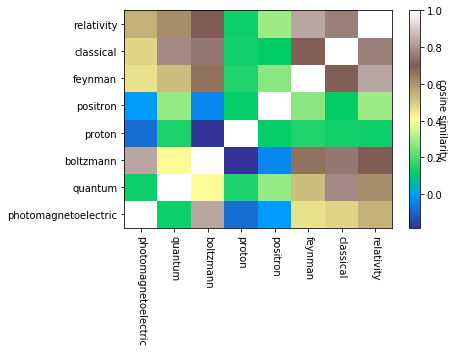

In [269]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [270]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

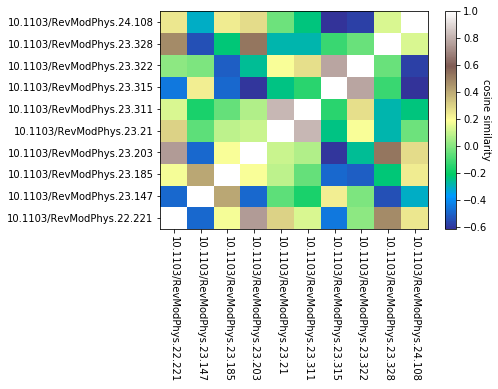

In [271]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [272]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

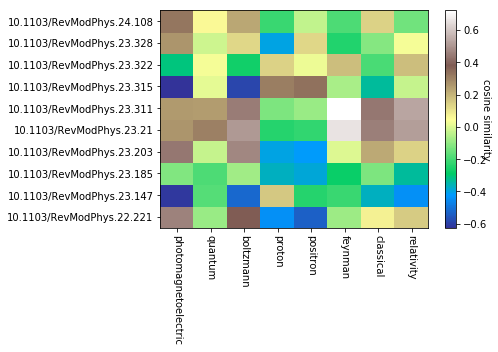

In [273]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [274]:
apsD2V.save('apsW2V')

We can later load it:

In [ ]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that build a doc2vec model with your corpus. Interrogate document and word relationships in the resulting space. Construct a heatmap that plots the distances between a subset of your documents against each other, and against a set of informative words. Find distances between *every* document in your corpus and a word or query of interest. What do these doc-doc proximities reveal about your corpus? What do these word-doc proximities highlight? Demonstrate and document one reasonable way to select a defensible subset of query-relevant documents for subsequent analysis.

## Data Processing

Again, my corpus contains 54 translated English novels from China, Korea, and U.S. So the total number of documents in my data is 54. The text is consists of 50 chapters from each book. Here, I will load the data, add a numeric series to indicate country of origin, and to modify some names of the novel.

In [293]:
bookDF = pandas.read_csv('bookDF.csv', sep = ';', usecols = list(range(1,5)))   
bookDF.loc[1:5]                                                                 
# create a numeric index                                                        
origin = []                                                                     
for element in bookDF['country']:                                               
    if element  == 'China':                                                     
        origin.append(0)                                                        
    if element == 'Korea':                                                      
        origin.append(1)                                                        
    if element == 'US':                                                         
        origin.append(2)                                                        
bookDF['origin'] = origin                                                       
# change book name a bit                                                        
bookDF['name'].loc[13] = 'Invincible Novel'                                     
bookDF['name'].loc[42] = 'Overgeared Novel'                                     
bookDF['name'].loc[45] = 'Breakers Novel' 
bookDF.loc[:10]

//anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,author,country,name,text,origin
0,Wang Yu,China,A Record of a Mortal's Journey to Immortality,“Second Fool” opened his eyes and stared at th...,0
1,I Am Superfluous,China,Ancient Strengthening Technique,This is a small village surrounded by hills an...,0
2,Yanbi Xiaosheng,China,Emperor's Domination,“Baa baa… baa baa… baa baa.” A young shepherd’...,0
3,Warring Blades,China,Imperial God Emperor,The time of 4 years quickly flew by. Ye Qingyu...,0
4,Ni Cangtian,China,Lord of All Realm,"Black Cloud City. The Nie clan. As night fell,...",0
5,Misty Rain of Jiangnan,China,Monarch of Evernight,Although it had been twelve hundred years sinc...,0
6,Er Geng,China,Renegade Immortal,Tie Zhu was sitting on the side of a little ro...,0
7,Against the Heavens,China,Spirit Realm,Ling Town. Early morning. Young Qin Lie blankl...,0
8,Xiao Jingyu,China,Talisman Emperor,Chen Xi Dusk fell upon Pine Mist City in the...,0
9,Sui Bo Zhu Liu,China,The Grandmaster Strategist,"In the sixteenth year of Xiande, Suiyun left J...",0


## Identify Keywords

Here, I will list a list of keywords. These keywords came up from my own reading interest. 

In [294]:
keywords = ['fight', 'master', 'protect', 'technique', 'god', 'sage', 'training', 'power', 'realm', 'karma', 'slay', 'gorgeous', 'beauty', 'goddess']

Tokenize and normalize text.

In [295]:
bookDF['tokenized_words'] = bookDF['text'].apply(lambda x: nltk.word_tokenize(x))
bookDF['normalized_words'] = bookDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

Choose country origin code and book name, because book names let us extract individual novels since book names are unique in my corpora.

In [296]:
# choose country and book name                                                  
taggedDocs = []                                                                 
for index, row in bookDF.iterrows():                                            
    #Just doing a simple keyword assignment                                     
    docKeywords = [s for s in keywords if s in row['normalized_words']]         
    docKeywords.append(row['origin'])                                           
    docKeywords.append(row['name']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
bookDF['TaggedText'] = taggedDocs 

Train a Doc2Vec model:

In [297]:
bookD2V = gensim.models.doc2vec.Doc2Vec(bookDF['TaggedText'], size = 100) #Limiting to 100 dimensions

## Exploratory Doc2Vec Analysis

Get vectors of Chinese novels:

In [299]:
bookD2V.docvecs[0]

array([ 1.3889927 ,  1.5600526 , -1.243665  , -1.9811964 , -2.874305  ,
        1.1958057 ,  0.63825804,  0.06178695, -1.039893  ,  2.3763666 ,
        1.0947529 ,  2.7474918 , -1.4493642 , -2.8228528 , -1.9460013 ,
        5.040361  ,  1.8393525 ,  0.31981358,  0.22857165,  0.6173374 ,
       -1.1659944 ,  0.26430088, -1.2730193 ,  2.4173717 , -0.5836058 ,
        4.131118  ,  0.31932673, -0.70739335, -0.40983066, -0.07579336,
        0.72754335,  2.604548  , -1.3918881 , -0.7553815 , -0.19349435,
        2.016749  , -1.7509768 ,  0.03822033,  0.11786569,  3.3686182 ,
       -2.4941547 ,  1.719854  ,  0.09009257,  1.5980353 , -1.779175  ,
       -0.20535246,  1.1561717 ,  1.2231771 , -0.18950298, -1.371747  ,
       -0.07108659,  2.4308305 ,  0.69242686, -2.3402596 ,  1.5934274 ,
        0.9499609 , -0.96208525,  2.7674656 ,  1.5225098 , -0.34153754,
       -1.6167859 ,  1.0983717 ,  0.94729006, -0.25871253,  0.69434744,
        1.2182268 ,  0.5097351 ,  0.11578968,  1.0481586 ,  1.21

Use the most_similar command to perform simple semantic equations and here comes an interesting observations:

Ceremony + teacher - study = ceremony. I think this is pretty interesting as I would expect to be some negative words describing students to be mischevious and messing around. But the returned word is actually ceremony. This matched Asian culture though as school and education is put on great emphasis. In these popular novels, they would likely to promote socially correct attitudes.

Also interesting finding is the accuracy of the semantic equation: village + people - farm = modern and food + land - eat = workers. These semantic equations makes intuitive sense if given background and relevant contexts, which is prettty interesting.

In [327]:
bookD2V.most_similar(positive = ['academy','teacher'], negative = ['study'], topn = 1)

[('ceremony', 0.9409565925598145)]

In [328]:
bookD2V.most_similar(positive = ['village', 'people'], negative = ['farm'], topn = 1)

[('modern', 0.8754010796546936)]

In [383]:
bookD2V.most_similar(positive = ['food', 'land'], negative = ['eat'], topn = 1)

[('workers', 0.9204472303390503)]

## Calculate the distance between a word and documents in the dataset 

I am interested in finding which books have widely used the word 'village'

In [332]:
bookD2V.docvecs.most_similar([ bookD2V['village'] ], topn=10 )   

[("Seoul Station's Necromancer", 0.772487998008728),
 ('Overgeared Novel', 0.7201688289642334),
 ('training', 0.7034971117973328),
 (1, 0.6700806617736816),
 ('Emperor of Solo Play', 0.6255255937576294),
 ('fight', 0.6108293533325195),
 ('power', 0.6007180213928223),
 ('Martial God Asura', 0.5986936092376709),
 ('Coiling Dragon', 0.5617974400520325),
 ('The Book Eating Magician', 0.536634087562561)]

I im interested in finding words most similar to this document: 

In [335]:
bookD2V.most_similar( [ bookD2V.docvecs['Perfect World'] ], topn=10)    

[('symbols', 0.897743284702301),
 ('animal', 0.8939039707183838),
 ('birds', 0.8834124803543091),
 ('attracting', 0.879669189453125),
 ('mutabeasts', 0.8594000339508057),
 ('swamp', 0.8536258935928345),
 ('beach', 0.8524145483970642),
 ('archaic', 0.8474878072738647),
 ('orb', 0.8379080891609192),
 ('dam', 0.8360435962677002)]

## Compose functions to easily plot heatmaps

Construct a function that could generate a heatmap of similarities among the keywords

In [368]:
def keyword_keyword(bookD2V, keywords):                                                                                                               
    heatmapMatrix = []                                                          
    for tagOuter in keywords:                                                   
        column = []                                                             
        tagVec = bookD2V.docvecs[tagOuter].reshape(1, -1)                       
        for tagInner in keywords:                                               
            column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, bookD2V.docvecs[tagInner].reshape(1, -1))[0][0])
        heatmapMatrix.append(column)                                            
    heatmapMatrix = np.array(heatmapMatrix)                                     
    fig, ax = plt.subplots(figsize=(15, 10))                                                    
    hmap = ax.pcolor(heatmapMatrix, cmap='terrain')                             
    cbar = plt.colorbar(hmap)                                                   
                                                                                
    cbar.set_label('cosine similarity', rotation=270)                           
    a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)     
    a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)     
                                                                                
    a = ax.set_xticklabels(keywords, minor=False, rotation=270)                 
    a = ax.set_yticklabels(keywords, minor=False) 

Construct a function that could generate a heatmap of similarities between the first several documents in the corpus

In [418]:
def doc_doc(bookDF, bookD2V, numBook):                                                                                                        
    targetDocs = bookDF['name'].loc[numBook]                                            
                                                                                
    heatmapMatrixD = []                                                         
                                                                                
    for tagOuter in targetDocs:                                                 
        column = []                                                             
        tagVec = bookD2V.docvecs[tagOuter].reshape(1, -1)                       
        for tagInner in targetDocs:                                             
            column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, bookD2V.docvecs[tagInner].reshape(1, -1))[0][0])
        heatmapMatrixD.append(column)                                           
    heatmapMatrixD = np.array(heatmapMatrixD)                                   
    # plot                                                                      
    fig, ax = plt.subplots(figsize=(15, 10))                                                    
    hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')                            
    cbar = plt.colorbar(hmap)                                                   
                                                                                
    cbar.set_label('cosine similarity', rotation=270)                           
    a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)    
    a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)    
                                                                                
    a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)               
    a = ax.set_yticklabels(targetDocs, minor=False)

Construct a function that could generate a heatmap of similarities between the first several documents in the corpus and keywords

In [374]:
def doc_words(bookD2V, keywords, numBook):                                               
    heatmapMatrixC = []
    targetDocs = bookDF['name'][:numBook]                                                                                                     
    for tagOuter in targetDocs:                                                 
        column = []                                                             
        tagVec = bookD2V.docvecs[tagOuter].reshape(1, -1)                       
        for tagInner in keywords:                                               
            column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, bookD2V.docvecs[tagInner].reshape(1, -1))[0][0])
        heatmapMatrixC.append(column)                                           
    heatmapMatrixC = np.array(heatmapMatrixC)                                   
    fig, ax = plt.subplots(figsize=(15, 10))                                                    
    hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')                            
    cbar = plt.colorbar(hmap)                                                   
                                                                                
    cbar.set_label('cosine similarity', rotation=270)                           
    a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)    
    a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)    
                                                                                
    a = ax.set_xticklabels(keywords, minor=False, rotation=270)                 
    a = ax.set_yticklabels(targetDocs, minor=False)

Construct a function that could generate a dataframe of showing distances between every document in your corpus and a word of interest

In [379]:
def distance_novel_word(bookDF, bookD2V, keywords):
    heatmapMatrixC = []
    targetDocs = bookDF['name'][:]                                                                                                     
    for tagOuter in targetDocs:                                                 
        column = []                                                             
        tagVec = bookD2V.docvecs[tagOuter].reshape(1, -1)                       
        for tagInner in keywords:                                               
            column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, bookD2V.docvecs[tagInner].reshape(1, -1))[0][0])
        heatmapMatrixC.append(column)                                           
    heatmapMatrixC = np.array(heatmapMatrixC)
    return pandas.DataFrame(heatmapMatrixC)

distance_novel_word(bookDF, bookD2V, ['fight'])

### Construct a heatmap that plots the distances between a subset of 20 novels against each other, 

Just a very general glance at the heatmap, surprisingly, we could see many dark/hot spots meaning many pairs of these novels are similiar to each other or we could say they have a relative small distances. Such observatiosns are more than the blue/cold spots, meaning many of these novels are similar than dissimilar in my corpus. So, I could claim many pairs of these translated Chinese and Korean novels are very similiar to each other in my corpus.

There are some interesting pairs of novels that are highly similiar to each other, and such pairs include: "The Great Ruler" and "Ancient Strengthening Technique", "Emperor's Domination" and "A Will Eternal", "Perfect World" and "The Great Ruler". Looking at the line of code below, we could see in this particular subset (top 20 novels in my dataframe), Er Geng wrote two of the novels, and they are "Renegade Immortal" and "A Will Eternal". 

Looking at "Renegade Immortal" and "A Will Eternal" in the heatmap,  we could see a fairly high cosine similarity score of approximately 0.5, meaning these two novels composed by author Er Geng's are pretty similar to each other. 

In [424]:
bookDF[['author', 'name']].loc[1:20].groupby('author').size()

author
Against the Heavens       1
Chen Dong                 1
Dancing                   1
Endless Sea of Clouds     1
Er Geng                   2
I Am Superfluous          1
Jiu Dang Jia              1
Kindhearted Bee           1
Misty Rain of Jiangnan    1
Ni Cangtian               1
Ni Tian Xie Shen          1
Shen Jian                 1
Sui Bo Zhu Liu            1
Tan Can Tu Dou            1
Tang Jia San Shao         1
Tian Can Tu Dou           1
Warring Blades            1
Xiao Jingyu               1
Yanbi Xiaosheng           1
dtype: int64

In [408]:
bookDF['name'].iloc[:20][bookDF['author']=='Er Geng']

6     Renegade Immortal
10       A Will Eternal
Name: name, dtype: object

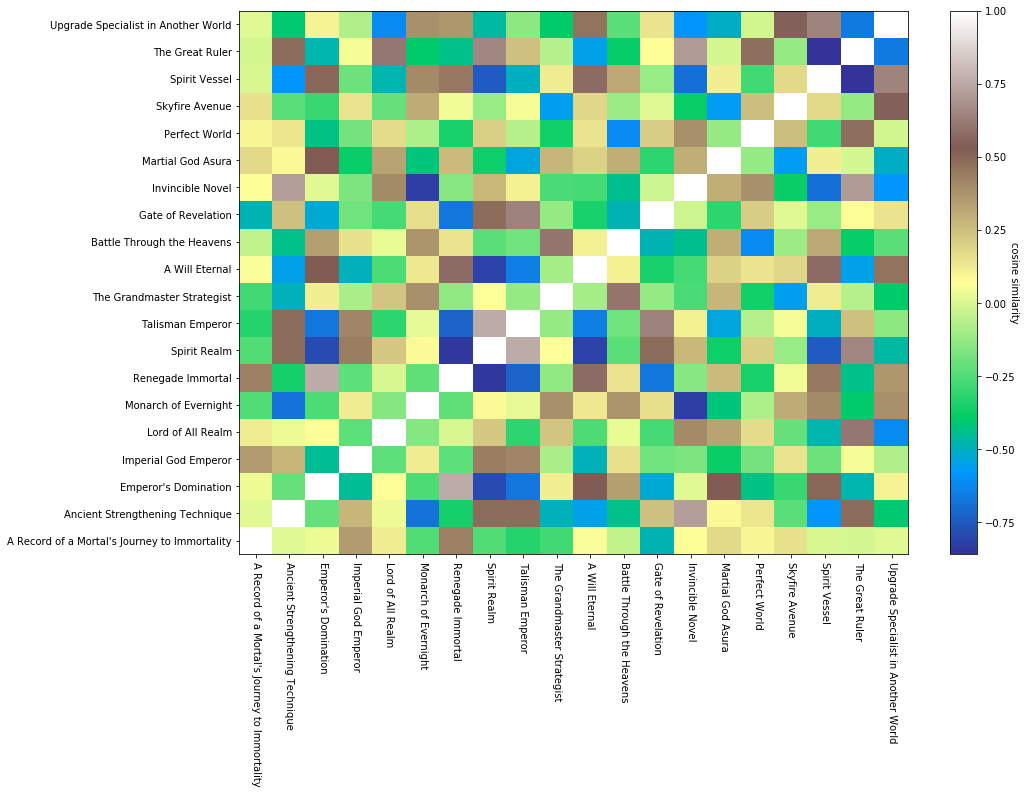

In [419]:
doc_doc(bookDF, bookD2V, range(20))

In [423]:
bookDF[['author', 'name']].loc[20:54].groupby('author').size()

author
Can Jian Li De Niu    1
Chwiryong             1
Crown                 1
D-Dart                1
Daman                 1
Deathblade            1
Er Geng               1
Fish Sky              1
Gu Long               3
Han Yeoul             1
I Eat Tomatoes        3
Kim Jae-Han           1
Lee Jungmin           1
Li Xianyu             1
Mad Snail             2
Mekenlo               1
Mibantan              1
Ni Tian Xie Shen      1
PALOW                 1
Park Saenal           1
Plow Days             1
Tang Jia San Shao     3
Tian Can Tu Dou       1
Tinalynge             1
Tipsy Wanderer        1
Toika                 1
Wen Chao Gong         1
dtype: int64

In [426]:
bookDF['name'].iloc[20:54][bookDF['author']=='I Eat Tomatoes']

22               Desolate Era
33             Coiling Dragon
37    Stellar Transformations
Name: name, dtype: object

In [427]:
bookDF['name'].iloc[20:54][bookDF['author']=='Mad Snail']

26    Rebirth of the Thief Who Roamed the World
28                     Tales of Demons and Gods
Name: name, dtype: object

In [428]:
bookDF['name'].iloc[20:54][bookDF['author']=='Gu Long']

30                       7 Killers
34    Dragon King With Seven Stars
39     Horizon, Bright Moon, Sabre
Name: name, dtype: object

After discovering the phenomenon that books written by the same author tend to have a high cosine similarity score, I decided to look at another subset to validate this finding. Here are three observations: 

- author "I Eat Tomatoes" (我吃西红柿) has three novels in my corpora, among which "Desolate Era" is highly similar with "Stellar Transformations"
- author "Mad Snail" （愤怒的蜗牛）has two novels in my corpora, but they are not similiar to each other.
- author "Gu Long" (古龙), one of the founding father of Eastern Fantasies in China, has three works in my corpora: "7 Killers" （七杀手）, "Dragon King With Seven Stars"（七星龙王）, and "Horizon, Bright Moon, Sabre" （天涯明月刀). It turns out that these three novels are all highly similiar to each other even more than 0.5.

This is some surprising finding because from my previous knowledge, I would expect a capable and well-known author is supposed to be able to write a diverse range of topics. However, according to this result, this might not be it. Successful novel writers could be very specific to one genre and be very good at it. Also, there could be a translation problem as well: maybe these authors are diverse, but because of English translation, a lot of information is confounded?!

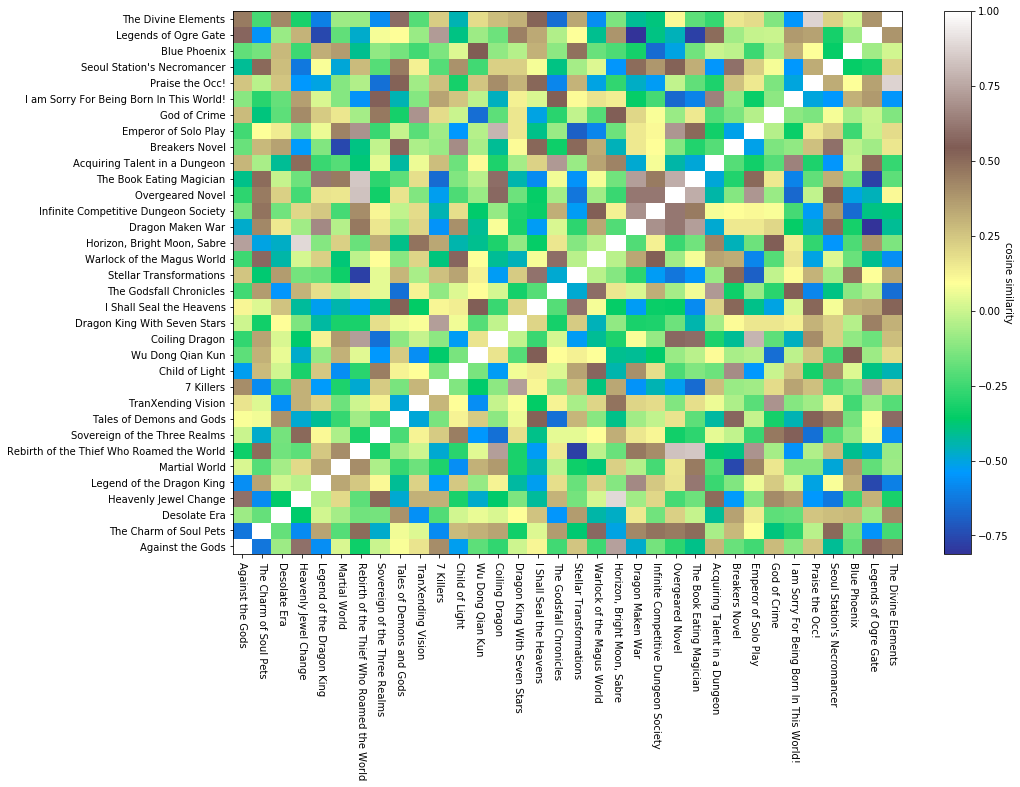

In [421]:
doc_doc(bookDF, bookD2V, range(20,54))

### Construct a heatmap that plots the distances between a subset of novels against a set of informative words.

Below is a heatmap plotting all books against each of the informative words. We could see that three columns, "goddess", "beauty" and "gorgeous" are among the ones have the greatest number of high cosine similarity scores. It makes sense since in most of these books, they would always describe femals to be beautiful and good-looking. Another interesting obserfvations is that "god" and "sage" are also among the popular ones because it seems that spiritual rituals are highly worshipped in the East Asian culture. 

What surpised me a little is the word "fight" does not have high cosine similarity score with many of the books. I think most of these novels contain scenes such as fighting the destiny, fighting the enemy, fighting brothers/rivals, fighting invaders. However, fight's cosine similarity score are not as high and as prevalent as the other ones among those 54 novels. 

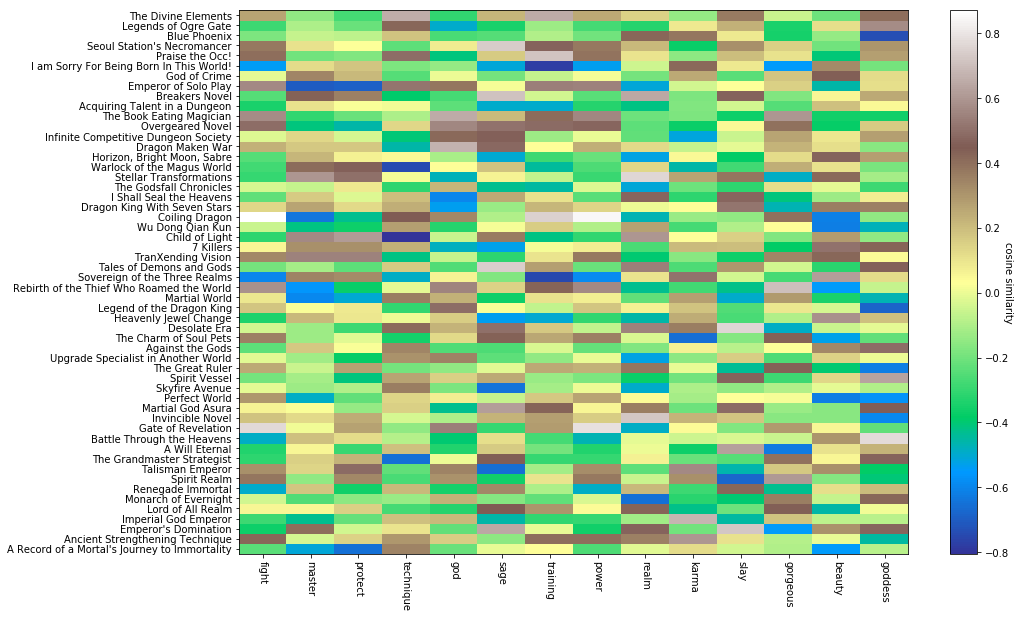

In [375]:
doc_words(bookD2V, keywords, 54)

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [279]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [280]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.343139, -0.117117, -0.50773 , ..., -0.995696,  0.921299,
         0.943769],
       [-0.362909, -0.263528,  0.032661, ..., -0.043032, -0.178965,
         0.353556],
       [-0.70167 , -0.344525, -0.320714, ...,  0.009001,  0.11055 ,
         0.751077],
       ...,
       [-2.391626, -1.90143 ,  1.031182, ...,  2.947464,  1.01588 ,
         2.00033 ],
       [-2.432387, -1.161415,  1.060064, ...,  4.402381,  0.500471,
         1.644596],
       [ 0.981931,  0.628094, -0.747547, ...,  1.612927,  1.148063,
         1.063776]], dtype=float32)

In [444]:
len(tnytTargetWords)

54

In [281]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

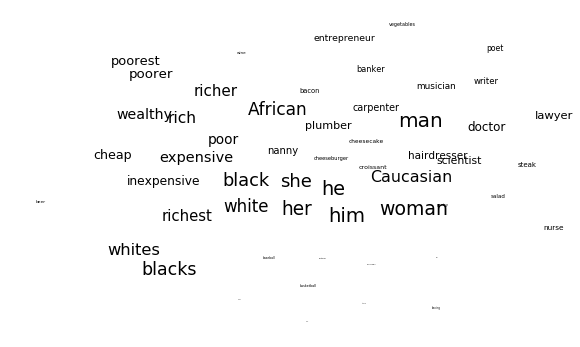

In [282]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  20 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [283]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [284]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [285]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [286]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [287]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [288]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

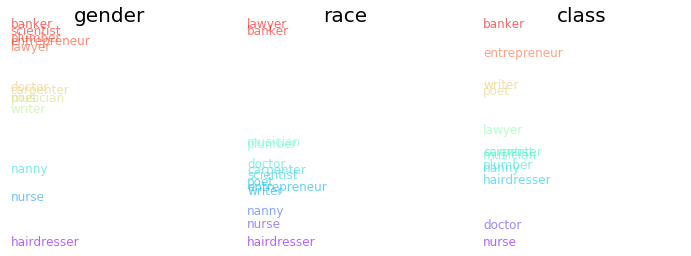

In [289]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

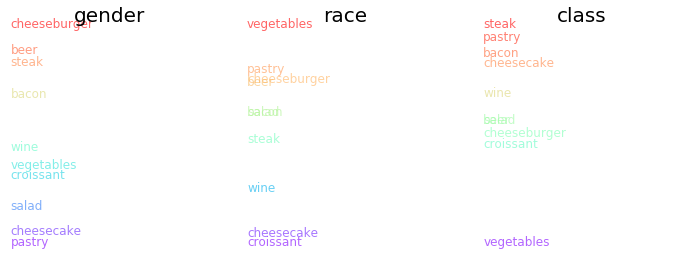

In [290]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

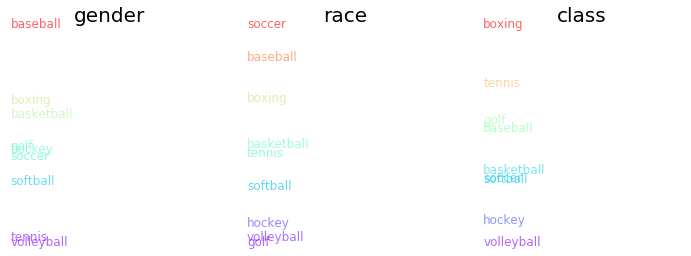

In [291]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify semantic dimensions of interest from your data (e.g., gender: man-woman) and project words onto these dimensions. Plot the array of relevant words along each semantic dimension. Which words are most different. Which dimensions are most different? On which dimension are your words most different? Print three short textual examples from the corpus that illustrate the association you have explored.

<span style="color:red">***Stretch***: Project documents from your corpus along a dimension of interest. Sample relevant documents from your corpus with this functionality and explain your rationale? Calculate the cosine of the angle between two dimensions (encoded as vectors) of interest. What does this suggest about the relationship between them within your corpus? 

<span style="color:red">***Stretch***: Create 90% bootstrap confidence intervals around your word projections onto a given dimension. Which words are *significantly* different on your semantic dimension of interest?

In this section of the assignment, my corpus would stay the same and I will be using the W2V model that was previously trained.

In [472]:
bookDF = pandas.read_csv('bookDF.csv', sep = ';', usecols = list(range(1,5)))   
bookDF['tokenized_sents'] = bookDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
bookDF['normalized_sents'] = bookDF['tokenized_sents'].apply(lambda x:          
             [lucem_illud.normalizeTokens(s,                                    
                                          stopwordLst = lucem_illud.stop_words_basic, 
                                          stemmer = None) for s in x])          
bookW2V = gensim.models.word2vec.Word2Vec(bookDF['normalized_sents'].sum())

## Visualize with dimension reduction

In [473]:
bookTargetWords = ['strong', 'weak', 'beautiful', 'ugly', 'handsome', 'ordinary', 'amazing', 'terrible', 'rich', 'richer', 'richest', 'expensive', 'cheap', 'poor', 'poorer', 'poorest', 'precious', 'mundane', 'normal', 'brilliant']
#words we will be mapping                                                       
bookTargetWords += ['master', 'god', 'sage', 'king', 'emperor', 'dominate', 'people', 'farmer', 'technique', 'skill', 'mountain', 'river', 'star', 'universe', 'territory', 'war', 'peace', 'train', 'lesson', 'death', 'suffer', 'die', 'survive', 'faint', 'hurt', 'medicine', 'spirit', 'winner', 'loser', 'suicide', 'murder', 'relationship', 'kin', 'village', 'sect', 'clan', 'palace']
                                                                                
wordsSubMatrix = []                                                             
for word in bookTargetWords:                                                    
    wordsSubMatrix.append(bookW2V[word])                                        
wordsSubMatrix = np.array(wordsSubMatrix)                                                                                                     
wordsSubMatrix          

array([[ 0.8963765 ,  0.15829481,  0.958538  , ..., -0.31318766,
        -0.41515124,  0.3463718 ],
       [ 0.3223732 , -0.6565061 ,  0.25746405, ..., -0.08303178,
        -1.0741493 ,  0.8851023 ],
       [-0.98626226, -0.6884069 ,  1.6757208 , ..., -0.40607297,
         0.8920307 ,  1.8546559 ],
       ...,
       [-0.5573061 , -0.77436745, -3.1793036 , ...,  0.4143422 ,
         1.9817108 ,  1.1675262 ],
       [-1.2297016 , -0.333926  , -1.0883712 , ...,  0.44591442,
         2.1133869 , -0.66263276],
       [ 0.7277357 , -0.1861147 , -0.5575086 , ..., -0.6803768 ,
         0.61449254, -0.5472551 ]], dtype=float32)

Dimension reduction using PCA Method

In [474]:
# PCA dimension reduction                                                       
pcaWordsBook = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix) 
reducedPCA_dataBook = pcaWordsBook.transform(wordsSubMatrix)                    
#T-SNE is theoretically better, but you should experiment                       
tsneWordsBook = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataBook)

Create word cloud 

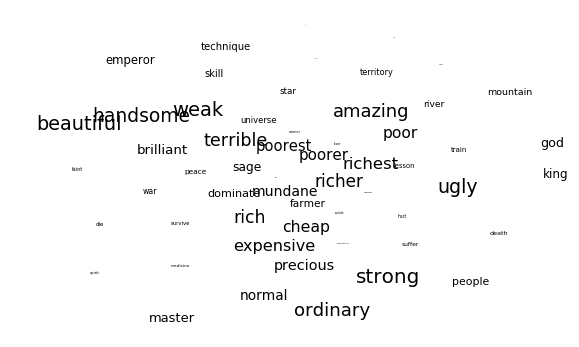

In [476]:
fig = plt.figure(figsize = (10,6))                                              
ax = fig.add_subplot(111)                                                       
ax.set_frame_on(False)                                                          
plt.scatter(tsneWordsBook[:, 0], tsneWordsBook[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(bookTargetWords):                                      
    ax.annotate(word, (tsneWordsBook[:, 0][i],tsneWordsBook[:, 1][i]), size =  20 * (len(bookTargetWords) - i) / len(bookTargetWords))
plt.xticks(())                                                                  
plt.yticks(())                                                                  
plt.show() 

I am interested in studying and exploring three dimensions: power, gender, and class. 

In Eastern Asian culture, power, gender, and class have their own unique categorizations and characteristics, which is easily identifiable. I am interested in exploring how these three dimensions categorize occupations, weapons, and abilities in eastern fantasies.

Define some convenient functions for getting dimensions.

In [482]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [491]:
Power = dimension(bookW2V, ['strong','skill','kill', 'win', 'chase'], ['weak', 'ordinary', 'die', 'lose', 'escape'])
Gender = dimension(bookW2V, ['handsome','masculine', 'mature'], ['beautiful', 'gorgeous', 'pretty'])
Class = dimension(bookW2V, ['king', 'palace', 'richest', 'expensive', 'luxury'], ['people', 'house', 'poorest', 'cheap', 'ordinary'])

Define several categories of words

In [500]:
Occupations = ["warrior","master","teacher","hunter","sage", "conqueror","defender","killer","assassin","mage", "murderer","support","god"]

Weapons = ["sword", "shield", "fan", "dagger", "arrow", "spear", "bow", "suit", "armor", "broadsword", "needle", "axe", "sickle"]

Ability  = ["technique", "skill", "magic", "spirit", "strategy", "tactic", "lie", "conspiracy", "ploy", "trick"]

Define a function to project words in a word list to each of the three dimensions.

In [501]:
def makeDF(model, word_list):
    p = []
    g = []
    c = []
    for word in word_list:
        p.append(sklearn.metrics.pairwise.cosine_similarity(bookW2V[word].reshape(1,-1), Power.reshape(1,-1))[0][0])
        g.append(sklearn.metrics.pairwise.cosine_similarity(bookW2V[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(bookW2V[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'power': p, 'gender': g, 'class': c}, index = word_list)
    return df

Get the projections.

In [502]:
OCCdf = makeDF(bookW2V, Occupations) 
Weapondf = makeDF(bookW2V, Weapons)
Abilitydf = makeDF(bookW2V, Ability)

Define some useful functions for plotting.

In [ ]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Define a function to calculate the difference of cosine similarity within a dimension

In [559]:
def dif_of_dif(df):
    return df.apply(max) - df.apply(min)

## Occupation

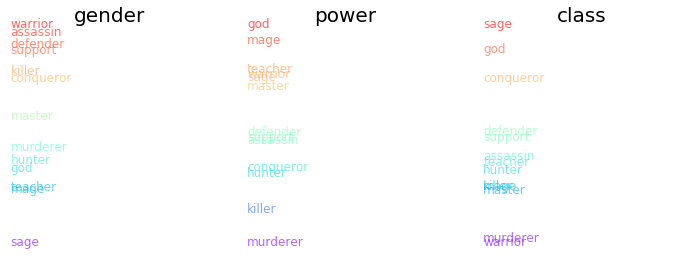

In [504]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'power')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

### Identify the most different dimension

In [560]:
dif_of_dif(OCCdf)

class     0.487599
gender    0.395804
power     0.518979
dtype: float64

Comparing the difference of differences in cosine similarity score, we could see that power is the most different dimension. We could also see how occupation is characterized in the three dimensions presented above. It seems males are more associated with occupations such as warriors, assassins, defender, andsupporter, while females are more associated with occupations such as teacher, mage, and sage. Interestingly, we could see god is also more feminine in Eastern Fantasies. Born and raised in China, I personally would attribute this categorization to culture because most of the time, Chinese people would typically associate and call beautiful women to goddess. 

Occupation in power dimension accurately reflected who is more powerful. God and mage is typically the most powerful occupation, which is understandable and straightforward. Very interesting finding is that the second most powerful group/cluster is: "teacher", "master", and "sage". In the Chinese culture, teachers and masters are well respected and would typically possess greater power in the power dynamics. It could be noticed that "conqurerpr" and "hunter" are grouped together as both occupations are in the pursuits.

In terms of class dimension, because the words I used to differentiate class are very materialistic, such as "poor" and "rich". So this dimensiuon accutrately reflected my word usage. Sage, god, and conqueror are the richest. Murder and worrior are typically the poorest.

### Texual Example

Worriors = Males?! Here is an example:

In [513]:
" ".join([element for element in bookDF['tokenized_sents'].sum() if "warrior" in element][0])

'All of the 3rd generation members had arrived , and those who were 6th grade martial warrior and higher ; Qing Zi , Qing You , Qing Hui , Qing Yang…………… Qing Hu and Qing Bei .'

God = Powerful? Here is an example. 

In [519]:
" ".join([element for element in bookDF['tokenized_sents'].sum() if "god" in element][7])

'You motherfucking… are you the reincarnation of the martial god ? ” The burly teacher was so shocked that he couldn ’ t help but swear .'

Sage = High class? Here is an example:

In [520]:
" ".join([element for element in bookDF['tokenized_sents'].sum() if "sage" in element][7])

'Was it possible that he was apprenticed to some ancient sage or extraordinary hermit who liked to live in the remote and secluded mountains ?'

## Weapon

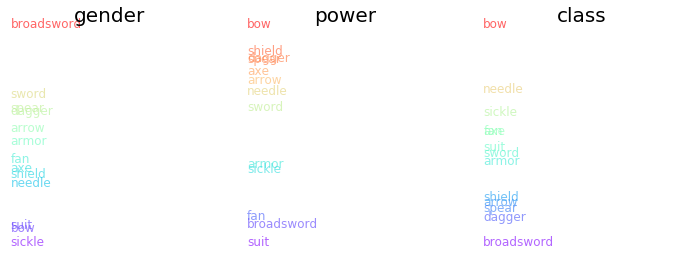

In [506]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Weapondf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Weapondf, 'power')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Weapondf, 'class')
plt.show()

## Identify the most different dimension

In [561]:
dif_of_dif(Weapondf)

class     0.456488
gender    0.415305
power     0.387410
dtype: float64

In this section, I am interested to see how would my model categorize weapons under these three dimensions. From the statistics shown above based on the difference of differences of cosine similarity scorem, we could see class is the most different dimension. In terms of gender, broadsword is strongly associatd to man, which makes sense. In the Chinese culture, it is very rare that female uses broadswords in any occasions. Interestingly, the book charactrize some very light-weight weapons, such as "needle", "bow", and "sickle" to be feminine. I think the categorization of weapon in this dimension is likely to be based on weights. 

I was a bit surprised to see bow to be on the very top of power dimensions. However, after going back to check my word of choice to define power dimension it makes sense. I used words such as "chase", "kill", "win" to define powerful. So, bow could be used in this occation: winning the fight, chasing enemy with a bow, and finally killed it. I also noticed suit, fan, and broadsword are at the very bottom of the dimension, which makes logical sense. A little note on broadsword. I think it is at the bottom becaus too many unimportant characters use this type of weapons thus downgraded its power. 

What suprised me the most is the categorization of weapon under class dimension. It could be possible that bows, according to these novels in my corpus, are always made of expensive and luxuary materials used by kings in the palace. The same applies to needle as well. It is noticeable that weapons with high class are light-weighted, thus more precious and more high class, which explained why broadsword is at the bottom of this dimension.



### Texual Examples

Here are two examples that broadswords are associated with males:

In [528]:
" ".join([element for element in bookDF['tokenized_sents'].sum() if "broadsword" in element][0])

'Twirling the broadsword in his hand , he hollered , “ Southern Chu brigands !'

In [525]:
" ".join([element for element in bookDF['tokenized_sents'].sum() if "broadsword" in element][4])

'“ Okay ! ” A youthful and loud voice responded , and with a broadsword , he swung down to behead Bei Feng .'

Classic sentence to show the power, class, and respect of bow and arrow:

In [531]:
" ".join([element for element in bookDF['tokenized_sents'].sum() if "bow" in element][3])

'Especially , an expert of the hidden weapons technique , they could be said to be almost invincible in the killing arts ; as the saying goes “ Any weapon out in the open can be dodged easily but an hidden arrow is hard to defend against ” , and also not to mention that the might of hidden weapons were incomparable to the bow and arrow .'

## Ability

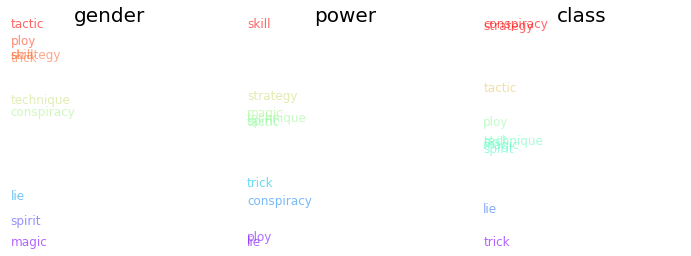

In [507]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Abilitydf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Abilitydf, 'power')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Abilitydf, 'class')
plt.show()

## Identify the most different dimension

In [562]:
dif_of_dif(Abilitydf)

class     0.502875
gender    0.353420
power     0.627096
dtype: float64

In this section, I am interested to see how would my model categorize ability under these three dimension. From the statistics shown above based on the difference of differences of cosine similarity scorem, we could see power is the most different dimension. In terms of gender, tactic seems to be associated with high masculinity. I think this is because in the Chinese culture, most of the commander in war are males. Following tactic, there is a cluster of words: "ploy", "strategy", "trick". I think these words are associated to males becasue these words are typically associated to warfars and commanding troops. Surprisingly, lie is more associated to feminine, which could potentially be a gender bias.

In the power dimension, skill are typically associated to the powerful, and ploy and lie are typically associated to the weak. Following skill, a cluster of words, such as "strategy", "technique", and "tactic" are also associated to people with greater power. In conclusion, we could know how the Eastern Asian culture value power and ability. I think this dimension is the most different as all words in showned above are clustered.

It is very interesting that "consparicy" and "strategy" are closely associated with people in upper class. I think this makes sense considering the words I used to train class dimension, which are 'king', 'palace', 'richest', 'expensive', 'luxury'. We would typically associate conspiracy and revolution in the palace or among the rich noble famalies. 

### Texual Example

Example of the usage of tactic:

In [536]:
" ".join([element for element in bookDF['tokenized_sents'].sum() if "tactic" in element][3])

'“ Clearly the enemy are certain that we don ’ t dare to come down from the mountain to counterattack so they use this ‘ cut flesh with a blunt knife ’ kind of tactic .'

Example of the usage of skill: a sword art master who created the technique

In [538]:
" ".join([element for element in bookDF['tokenized_sents'].sum() if "skill" in element][20])

'Those who complained did not know that the Elder who created this particular sword art had a very deep and profound level of skill .'

Example of the usage of conspiracy: related to city usually used by poeple in high class.

In [539]:
" ".join([element for element in bookDF['tokenized_sents'].sum() if "conspiracy" in element][20])

'Perhaps so , but that still doesn ’ t mean Iron Awl Hu is involved in some conspiracy to sell the city to the Demon Emperor. ” Sun Mai sighed , placed his elbow on his knee , and then rested his chin on his hand .'